## Nasa predictive Maintenance (RUL)
- https://www.kaggle.com/code/wassimderbel/nasa-predictive-maintenance-rul

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

- 비행기의 RUL을 예측

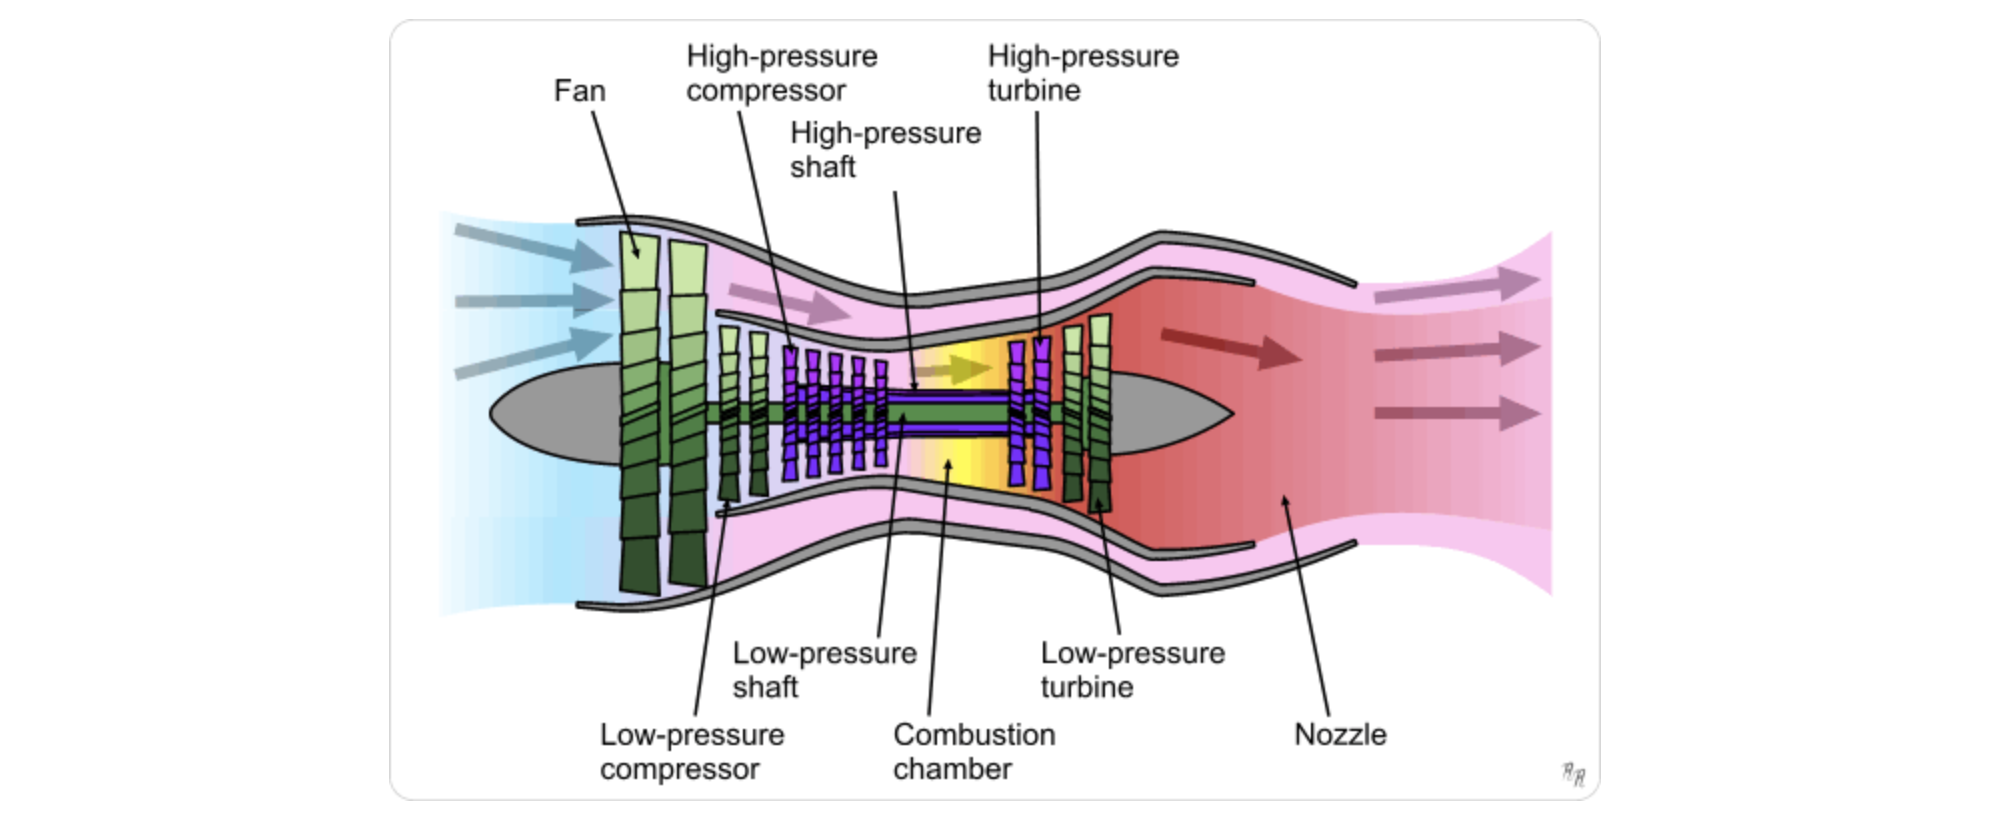

In [2]:
from sklearn.ensemble import RandomForestRegressor
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random

In [3]:
np.random.seed(34)

피처명 정의

In [7]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names
print(col_names)

['unit_number', 'time_cycles', 'setting_1', 'setting_2', 'setting_3', 's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20', 's_21']


In [5]:
os.listdir("data/CMaps/")

['Damage Propagation Modeling.pdf',
 'train_FD001.txt',
 'train_FD003.txt',
 'RUL_FD004.txt',
 'train_FD002.txt',
 'RUL_FD001.txt',
 'x.txt',
 'RUL_FD003.txt',
 'RUL_FD002.txt',
 'train_FD004.txt',
 'test_FD003.txt',
 'test_FD002.txt',
 'test_FD001.txt',
 'test_FD004.txt',
 'readme.txt']

HPC failure와 관련된 서브데이터셋이 FD001이다.

In [8]:
df_train = pd.read_csv("data/CMaps/train_FD001.txt", sep="\s+",
                       header=None, 
                       index_col = False,
                       names = col_names
                       )

df_valid = pd.read_csv("data/CMaps/test_FD001.txt", sep="\s+",
                       header=None, 
                       index_col = False,
                       names = col_names
                       )

y_valid = pd.read_csv("data/CMaps/RUL_FD001.txt", sep="\s+",
                       header=None, 
                       index_col = False,
                       names = ["RUL"]
                       )


In [9]:
df_valid.shape

(13096, 26)

In [10]:
train = df_train.copy()
valid = df_valid.copy()

### Data inspection

In [12]:
train.head()

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0            1            1    -0.0007    -0.0004      100.0  518.67  641.82   
1            1            2     0.0019    -0.0003      100.0  518.67  642.15   
2            1            3    -0.0043     0.0003      100.0  518.67  642.35   
3            1            4     0.0007     0.0000      100.0  518.67  642.35   
4            1            5    -0.0019    -0.0002      100.0  518.67  642.37   

       s_3      s_4    s_5  ...    s_12     s_13     s_14    s_15  s_16  s_17  \
0  1589.70  1400.60  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03   392   
1  1591.82  1403.14  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03   392   
2  1587.99  1404.20  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03   390   
3  1582.79  1401.87  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03   392   
4  1582.85  1406.22  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03   393   

   s_18   s_19   s_20     s_21  
0  2388  100.0  39.06  23.4190  
1  2388  100.0  39.00  23.4236  
2  2388  100.0  38.95  23.3442  
3  2388  100.0  38.88  23.3739  
4  2388  100.0  38.90  23.4044  

[5 rows x 26 columns]

In [13]:
train.shape

(20631, 26)

In [14]:
print(train.shape)
print(valid.shape)
print(len(valid)/(len(valid) + len(train)))

(20631, 26)
(13096, 26)
0.3882942449669404


In [15]:
train.isnull().sum()

unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64

In [16]:
train.loc[:, ["unit_number", "time_cycles"]].describe()

unit_number   time_cycles
count  20631.000000  20631.000000
mean      51.506568    108.807862
std       29.227633     68.880990
min        1.000000      1.000000
25%       26.000000     52.000000
50%       52.000000    104.000000
75%       77.000000    156.000000
max      100.000000    362.000000

unit number는 예상대로 1에서 시작하여 100에서 끝나는 것을 볼 수 있습니다.  
흥미로운 점은 평균과 사분위수가 1~100 사이의 벡터의 설명 통계와 깔끔하게 일치하지 않는다는 것인데, 이는 각 단위가 최대 시간_주기가 다르고 따라서 행의 수가 다르기 때문으로 설명할 수 있습니다.  
최대 시간_주기를 살펴보면 가장 빨리 고장난 엔진은 128주기 후에 고장난 반면, 가장 오래 작동한 엔진은 362주기 후에 고장난 것을 볼 수 있습니다.  
평균 엔진 고장은 199~206사이클이지만 표준 편차는 46사이클로 다소 큽니다. 더 나은 이해를 돕기 위해 아래에서 이를 시각화해 보겠습니다.

In [17]:
train.loc[:, 's_1':].describe().transpose()

count         mean           std        min        25%        50%  \
s_1   20631.0   518.670000  6.537152e-11   518.6700   518.6700   518.6700   
s_2   20631.0   642.680934  5.000533e-01   641.2100   642.3250   642.6400   
s_3   20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600  1590.1000   
s_4   20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600  1408.0400   
s_5   20631.0    14.620000  3.394700e-12    14.6200    14.6200    14.6200   
s_6   20631.0    21.609803  1.388985e-03    21.6000    21.6100    21.6100   
s_7   20631.0   553.367711  8.850923e-01   549.8500   552.8100   553.4400   
s_8   20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500  2388.0900   
s_9   20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000  9060.6600   
s_10  20631.0     1.300000  4.660829e-13     1.3000     1.3000     1.3000   
s_11  20631.0    47.541168  2.670874e-01    46.8500    47.3500    47.5100   
s_12  20631.0   521.413470  7.375534e-01   518.6900   520.9600   521.4800   
s_13  20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400  2388.0900   
s_14  20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450  8140.5400   
s_15  20631.0     8.442146  3.750504e-02     8.3249     8.4149     8.4389   
s_16  20631.0     0.030000  1.556432e-14     0.0300     0.0300     0.0300   
s_17  20631.0   393.210654  1.548763e+00   388.0000   392.0000   393.0000   
s_18  20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000   
s_19  20631.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
s_20  20631.0    38.816271  1.807464e-01    38.1400    38.7000    38.8300   
s_21  20631.0    23.289705  1.082509e-01    22.8942    23.2218    23.2979   

            75%        max  
s_1    518.6700   518.6700  
s_2    643.0000   644.5300  
s_3   1594.3800  1616.9100  
s_4   1414.5550  1441.4900  
s_5     14.6200    14.6200  
s_6     21.6100    21.6100  
s_7    554.0100   556.0600  
s_8   2388.1400  2388.5600  
s_9   9069.4200  9244.5900  
s_10     1.3000     1.3000  
s_11    47.7000    48.5300  
s_12   521.9500   523.3800  
s_13  2388.1400  2388.5600  
s_14  8148.3100  8293.7200  
s_15     8.4656     8.5848  
s_16     0.0300     0.0300  
s_17   394.0000   400.0000  
s_18  2388.0000  2388.0000  
s_19   100.0000   100.0000  
s_20    38.9500    39.4300  
s_21    23.3668    23.6184

Data visualization & Feature engineering  
Max time cycle found for each Unit  

Let us see the maximum time cycle of each unit  

In [22]:
max_time_cycles = train[index_names].groupby("unit_number").max()
max_time_cycles

time_cycles
unit_number             
1                    192
2                    287
3                    179
4                    189
5                    269
...                  ...
96                   336
97                   202
98                   156
99                   185
100                  200

[100 rows x 1 columns]

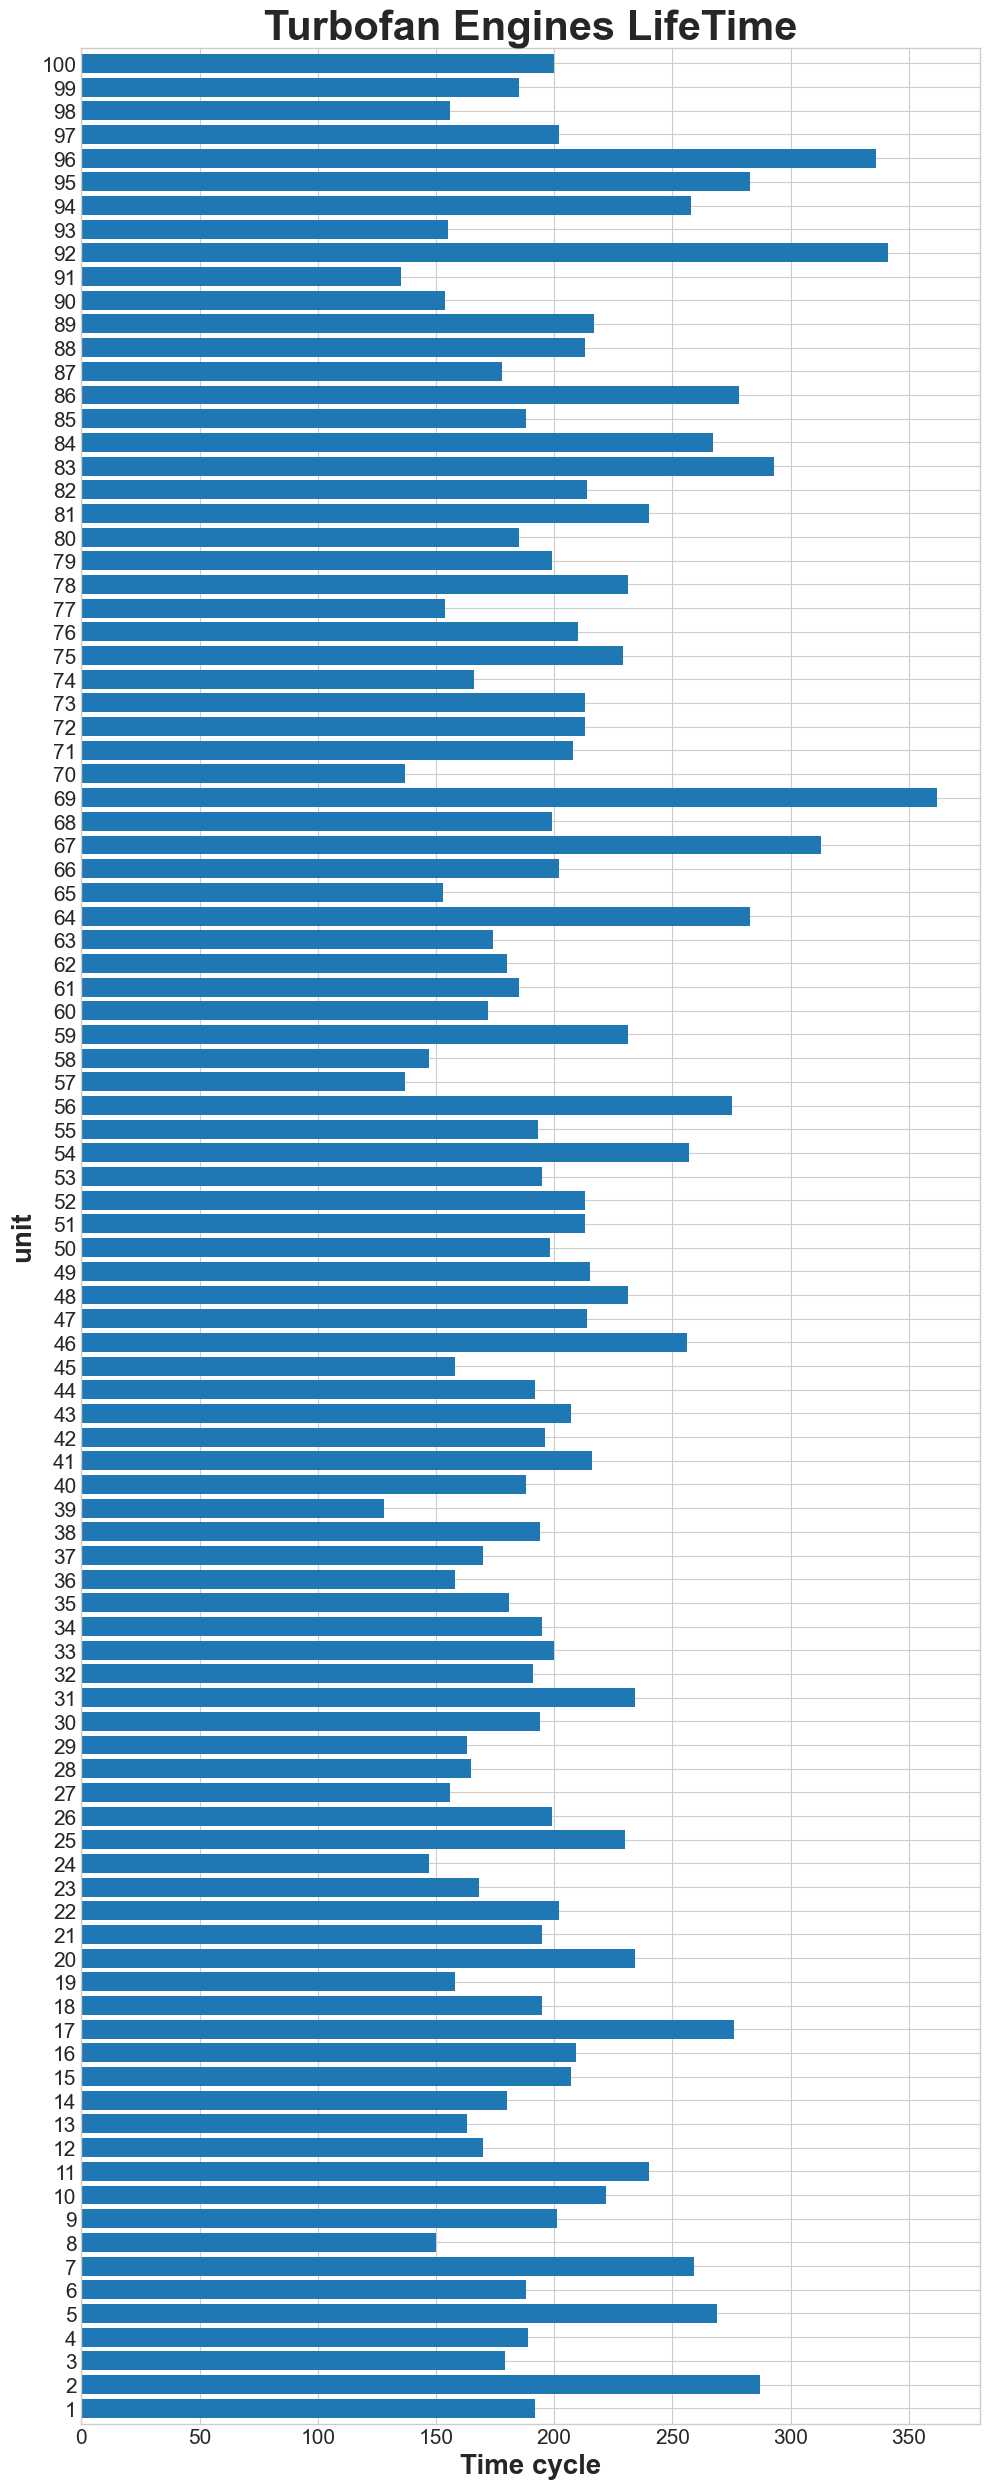

In [23]:
plt.figure(figsize=(10,25))
ax=max_time_cycles['time_cycles'].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
plt.xlabel('Time cycle',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('unit',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 9.444444444444455, 'max time cycle')

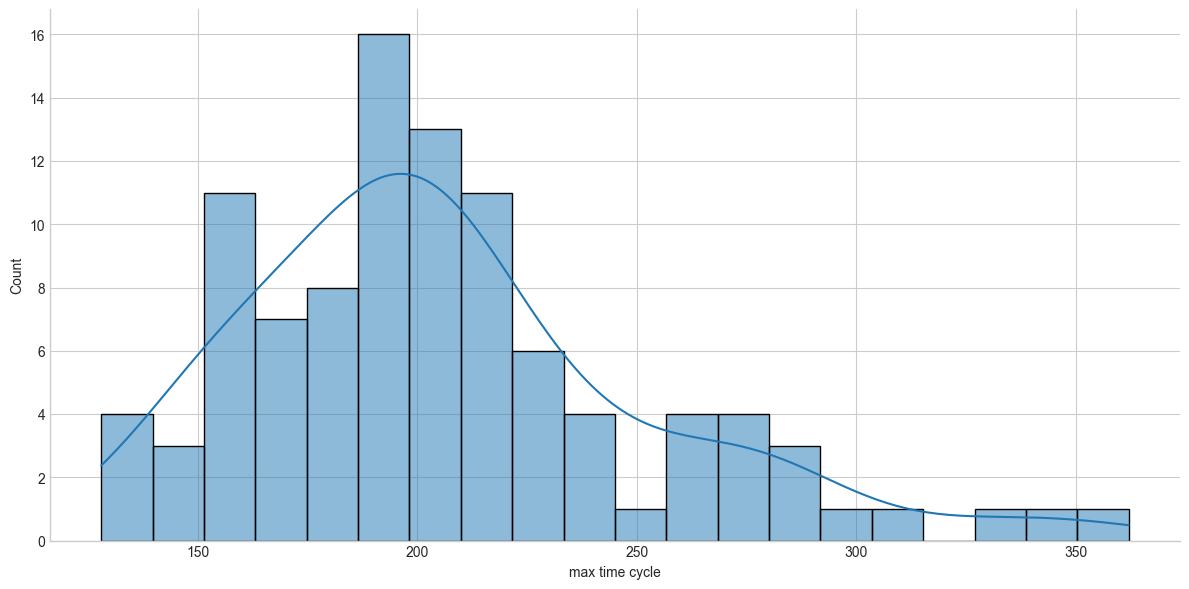

In [24]:
#Distribution of maximum time cycles
sns.displot(max_time_cycles['time_cycles'],kde=True,bins=20,height=6,aspect=2)
plt.xlabel('max time cycle')

Add RUL column to the data

RUL corresponds to the remaining time cycles for each unit before it fails.

In [31]:
def add_RUL_column(df):
    train_grouped_by_unit = df.groupby(by = "unit_number")
    max_time_cycles = train_grouped_by_unit["time_cycles"].max()
    merged = df.merge(max_time_cycles.to_frame(name = 'max_time_cycle'),
                      left_on = 'unit_number',
                      right_index = True
                      )
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    merged = merged.drop('max_time_cycle', axis = 1)
    return merged

In [32]:
train = add_RUL_column(train)
train[['unit_number', 'RUL']]

unit_number  RUL
0                1  191
1                1  190
2                1  189
3                1  188
4                1  187
...            ...  ...
20626          100    4
20627          100    3
20628          100    2
20629          100    1
20630          100    0

[20631 rows x 2 columns]

In [33]:
# RUL 분석
maxrul_u = train.groupby('unit_number').max().reset_index()
maxrul_u

unit_number  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0             1          192     0.0047     0.0005      100.0  518.67  644.21   
1             2          287     0.0076     0.0006      100.0  518.67  643.94   
2             3          179     0.0058     0.0005      100.0  518.67  643.93   
3             4          189     0.0059     0.0006      100.0  518.67  644.53   
4             5          269     0.0055     0.0005      100.0  518.67  644.02   
..          ...          ...        ...        ...        ...     ...     ...   
95           96          336     0.0049     0.0005      100.0  518.67  644.20   
96           97          202     0.0050     0.0006      100.0  518.67  643.97   
97           98          156     0.0077     0.0004      100.0  518.67  644.39   
98           99          185     0.0059     0.0005      100.0  518.67  644.10   
99          100          200     0.0056     0.0004      100.0  518.67  643.95   

        s_3      s_4    s_5  ...     s_13     s_14    s_15  s_16  s_17  s_18  \
0   1605.44  1432.52  14.62  ...  2388.35  8140.58  8.5227  0.03   398  2388   
1   1610.10  1431.17  14.62  ...  2388.26  8175.57  8.5377  0.03   398  2388   
2   1606.50  1438.51  14.62  ...  2388.20  8255.34  8.5363  0.03   399  2388   
3   1612.11  1434.12  14.62  ...  2388.17  8259.42  8.5462  0.03   399  2388   
4   1609.41  1434.59  14.62  ...  2388.23  8215.19  8.5410  0.03   398  2388   
..      ...      ...    ...  ...      ...      ...     ...   ...   ...   ...   
95  1608.62  1432.65  14.62  ...  2388.28  8146.04  8.5615  0.03   398  2388   
96  1610.66  1430.66  14.62  ...  2388.17  8270.91  8.5596  0.03   400  2388   
97  1606.24  1432.16  14.62  ...  2388.30  8156.01  8.5308  0.03   396  2388   
98  1616.91  1436.54  14.62  ...  2388.33  8145.61  8.5592  0.03   397  2388   
99  1610.87  1433.58  14.62  ...  2388.28  8150.68  8.5646  0.03   398  2388   

     s_19   s_20     s_21  RUL  
0   100.0  39.18  23.4999  191  
1   100.0  39.24  23.6005  286  
2   100.0  39.23  23.5181  178  
3   100.0  39.21  23.5074  188  
4   100.0  39.29  23.5503  268  
..    ...    ...      ...  ...  
95  100.0  39.18  23.5344  335  
96  100.0  39.22  23.5181  201  
97  100.0  39.30  23.5461  155  
98  100.0  39.20  23.4986  184  
99  100.0  39.18  23.5751  199  

[100 rows x 27 columns]

correlations

<Axes: >

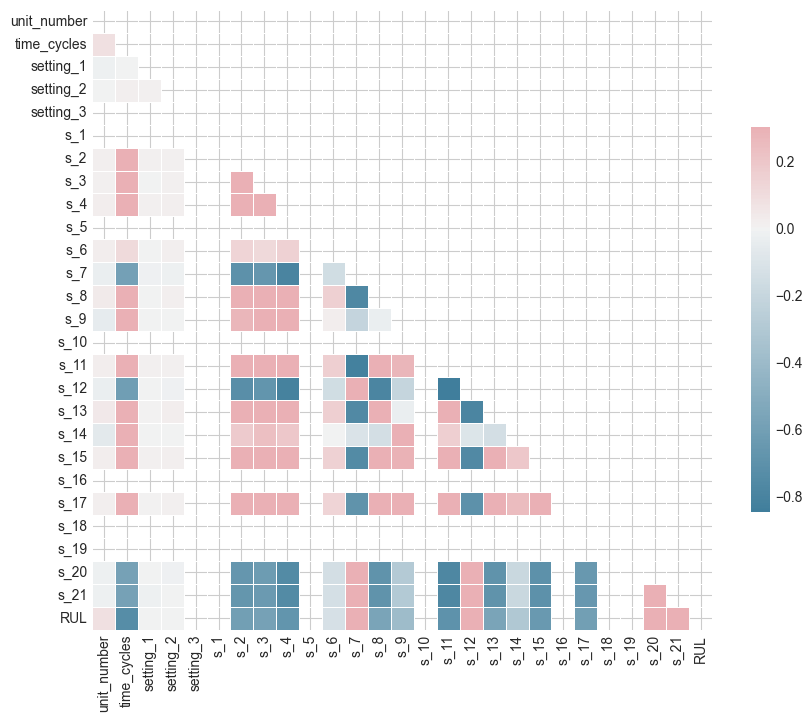

In [34]:
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize = (10, 10))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

Questions to answer :
- Can we efficiently predict the remaining useful time for the engine (error significance) ?
- Which features are the most important for predicting the failure of the turbofan engine ?
- Does adding historical data improve our model ?
- Is the collected data sufficient enough to give an accurate prediction ?
- How can we turn our problem to a classification one ?

In [35]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['s_'+str(i)]=x
    i+=1
Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

저압 압축기(LPC)와 고압 압축기(HPC)는 압축된 고온, 고압 가스를 연소기에 공급합니다.  
저압 터빈(LPT)은 공기를 감속하고 가압하여 항공 등유의 화학 에너지 변환 효율을 개선할 수 있습니다.  
고압 터빈(HPT)은 고온 및 고압 가스가 터빈 블레이드를 타격하여 기계적 에너지를 생성합니다.  
저압 로터(N1), 고압 로터(N2), 노즐은 엔진의 연소 효율을 보장합니다.

In [36]:
def plot_signal(df, Sensor_dic, signal_name):
    plt.figure(figsize = (13, 5))
    for i in df['unit_number'].unique():
        if (i % 10 ==0):
            plt.plot("RUL", signal_name, data = df[df['unit_number'] == i].rolling(10).mean()) 
            
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(Sensor_dic[signal_name])
    plt.xlabel('Remaining Useful Life')
    plt.show()

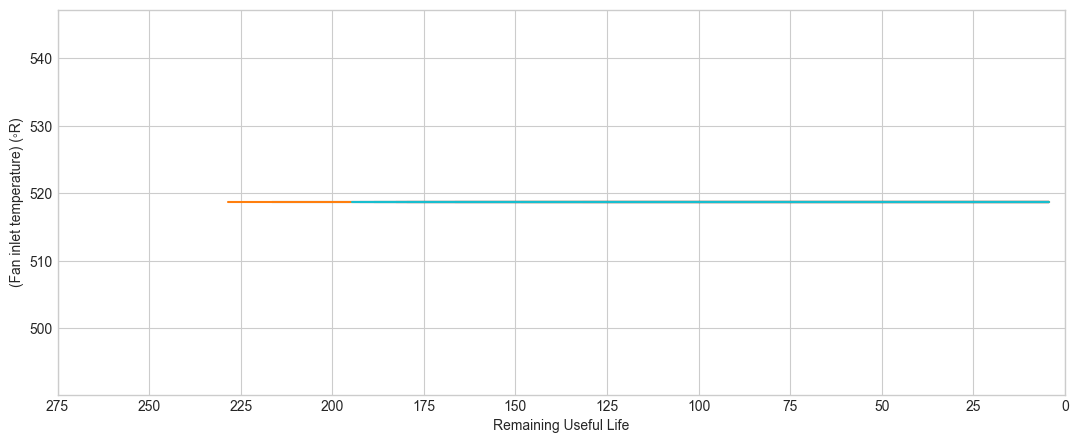

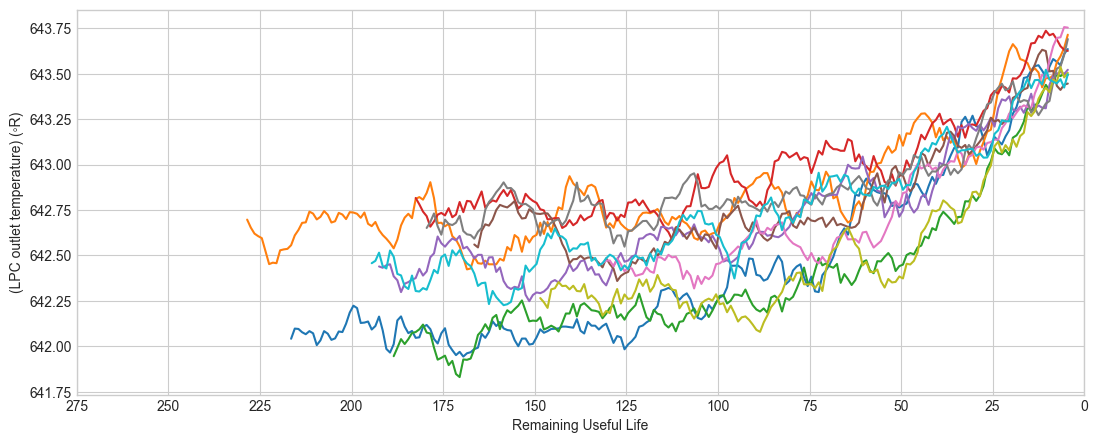

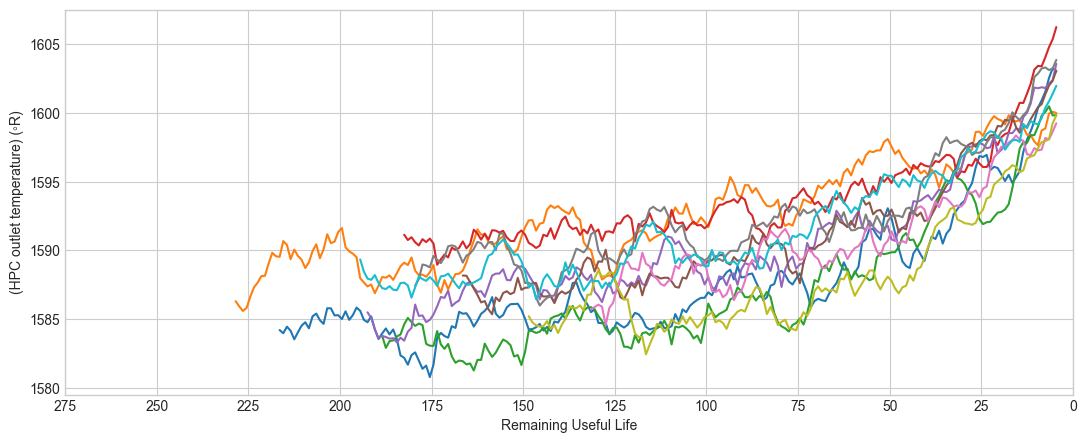

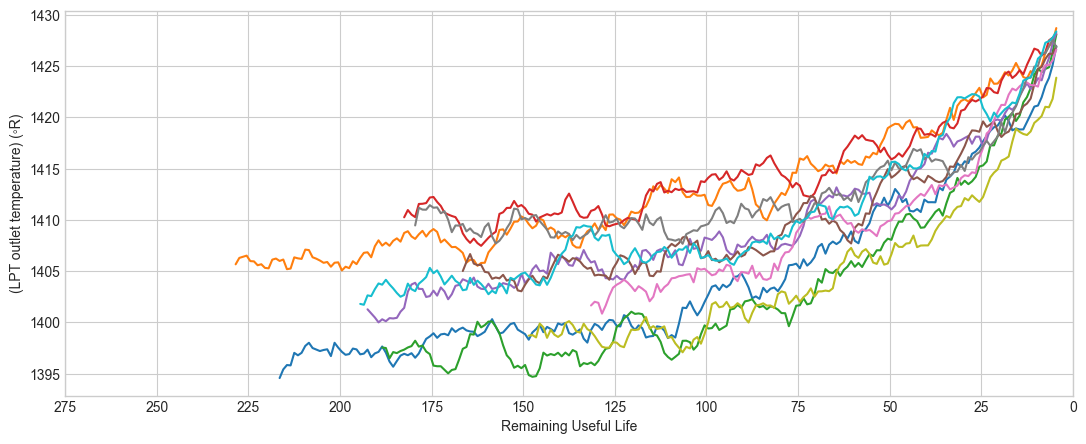

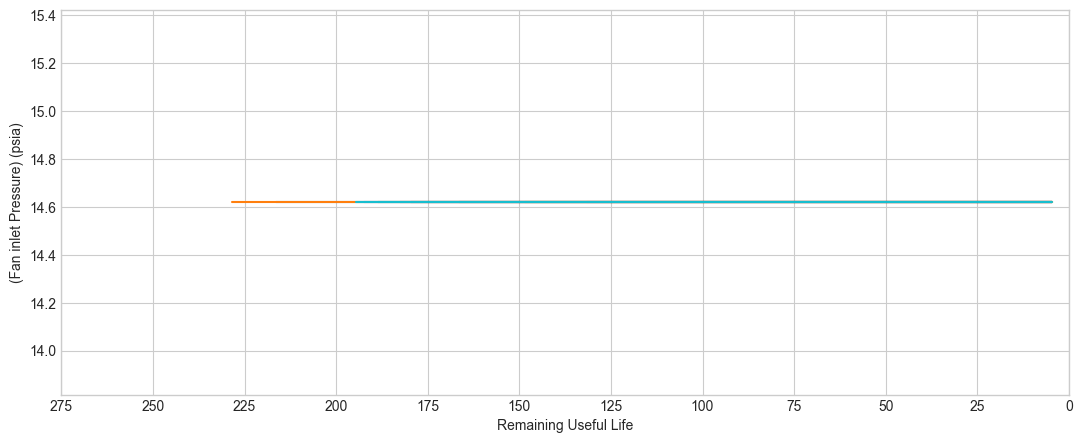

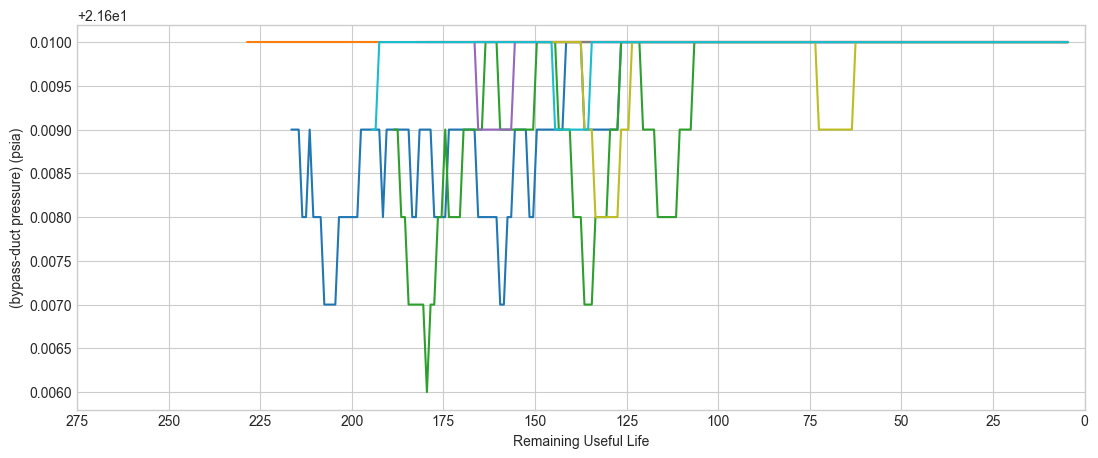

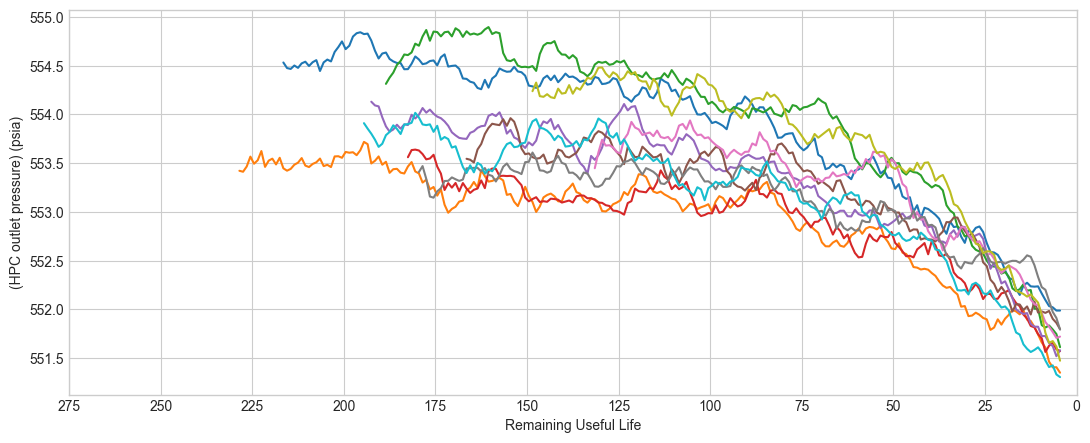

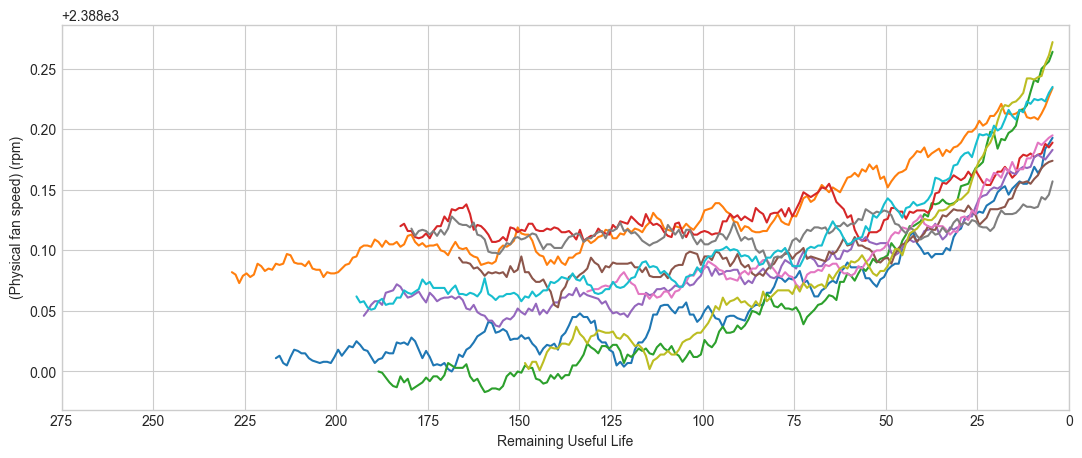

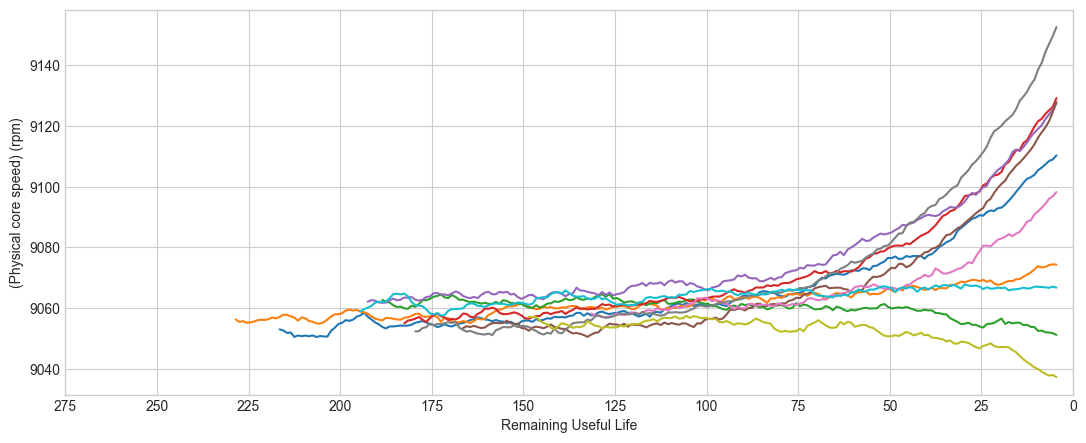

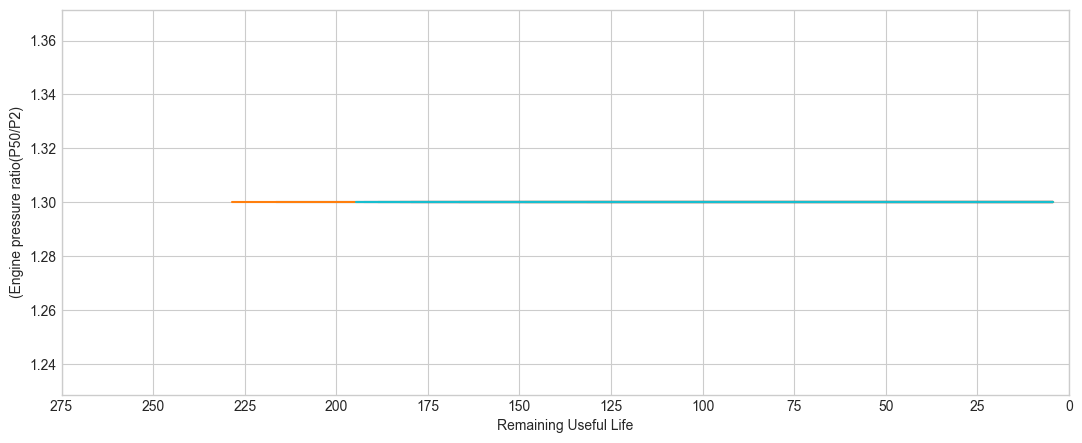

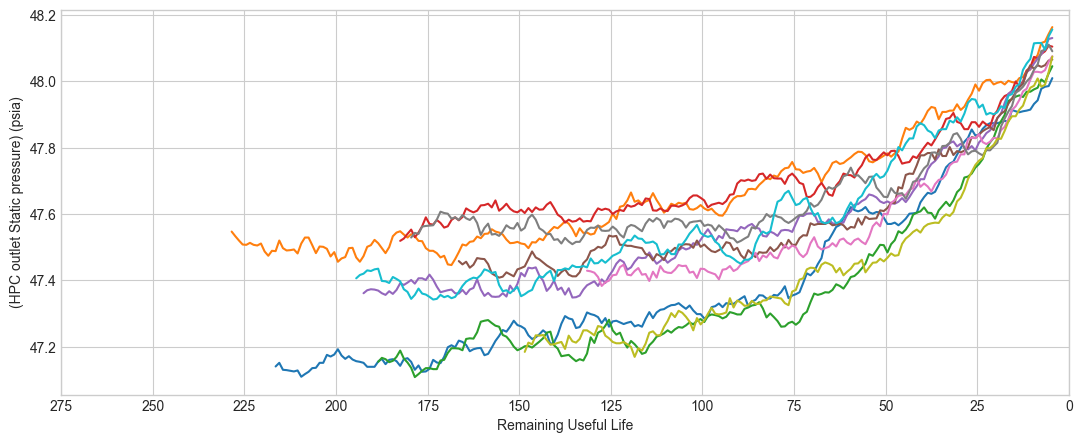

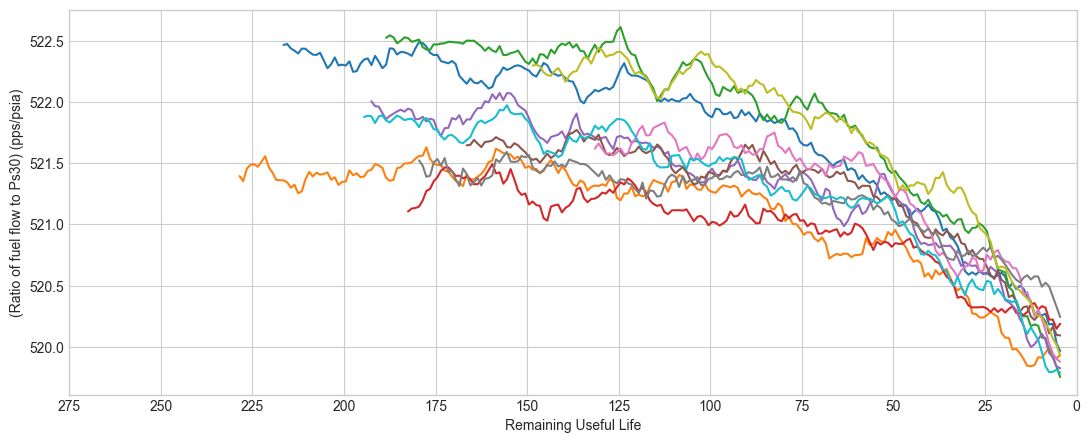

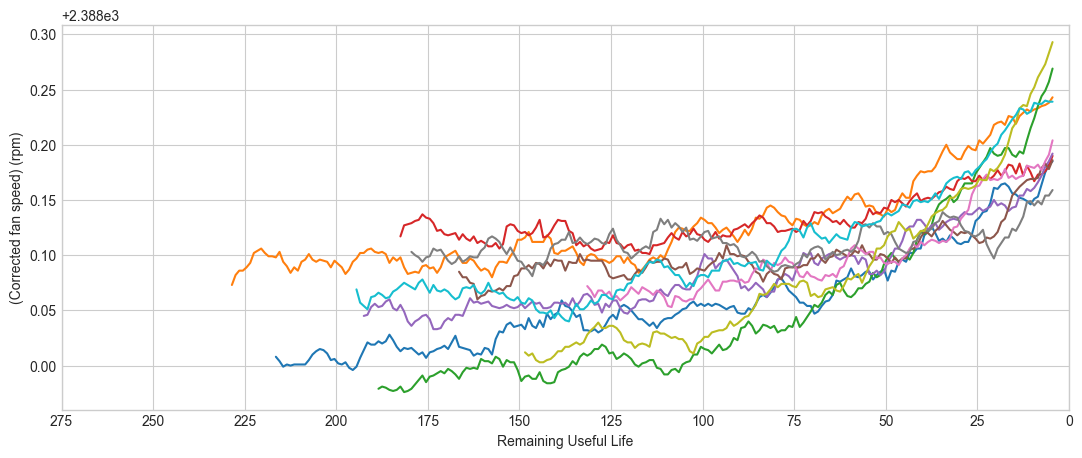

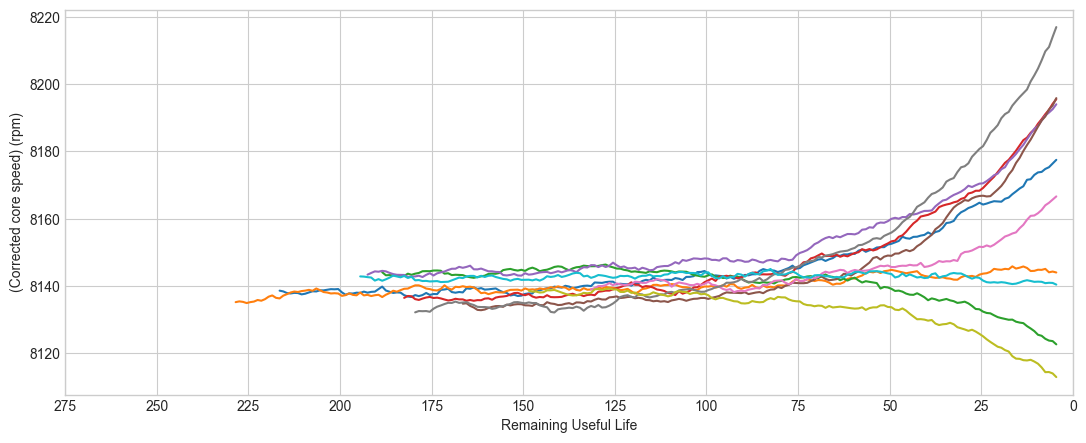

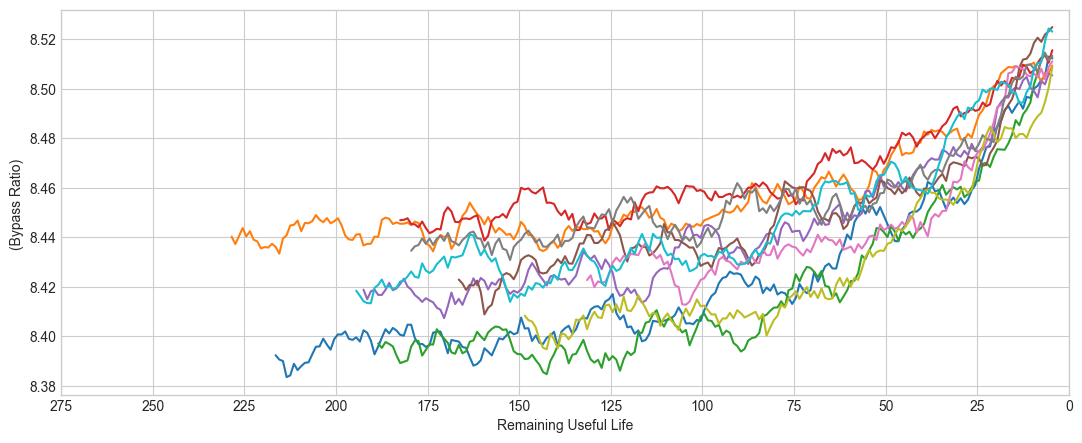

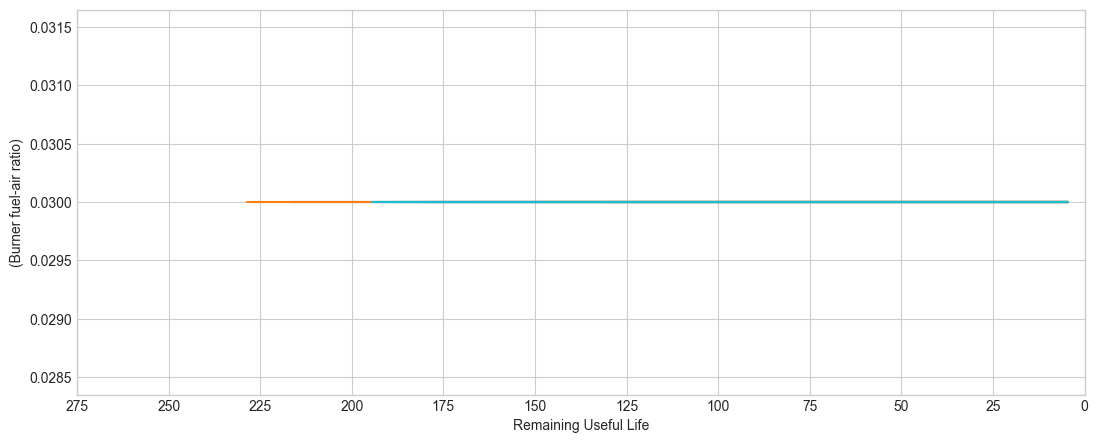

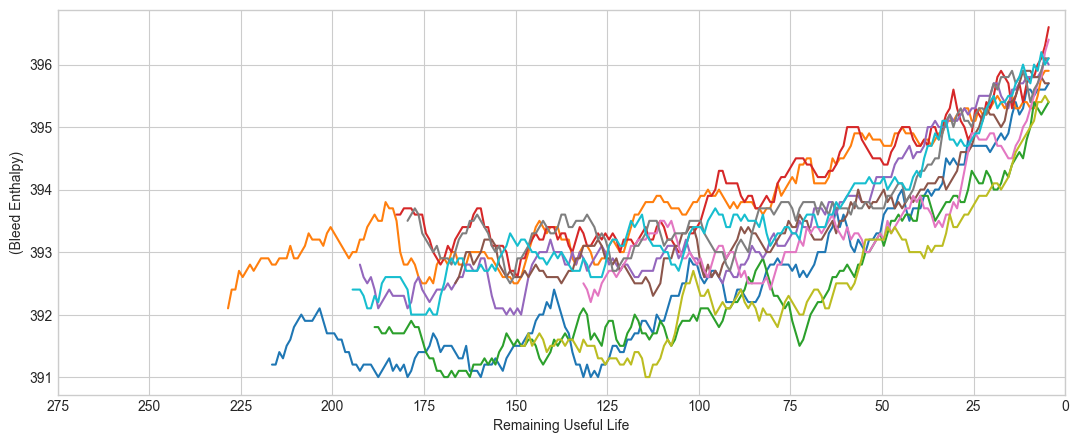

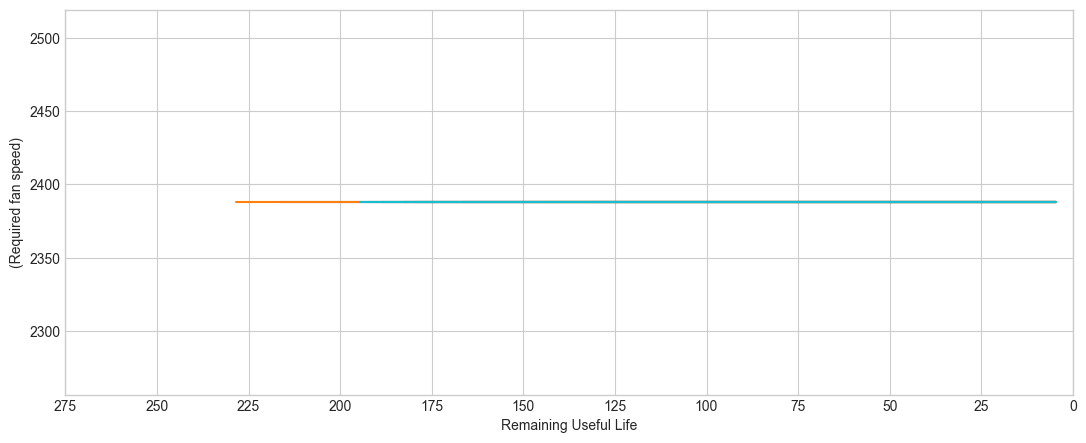

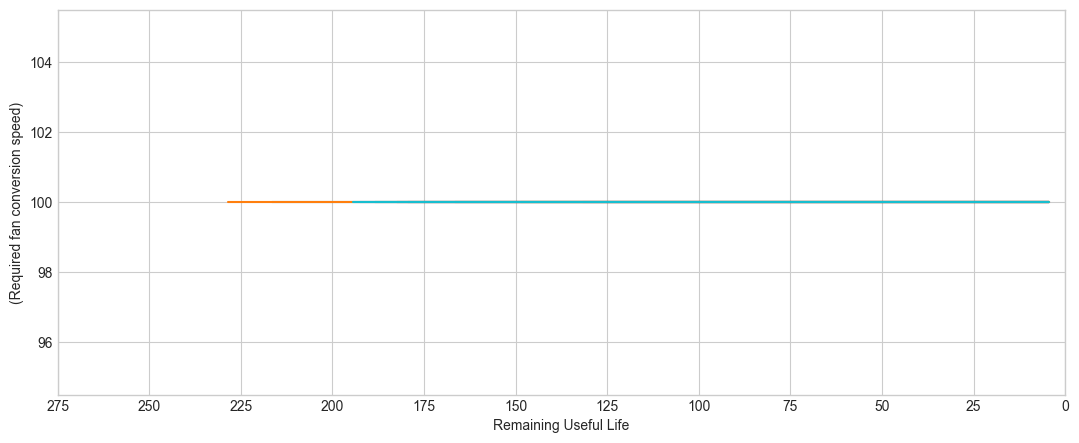

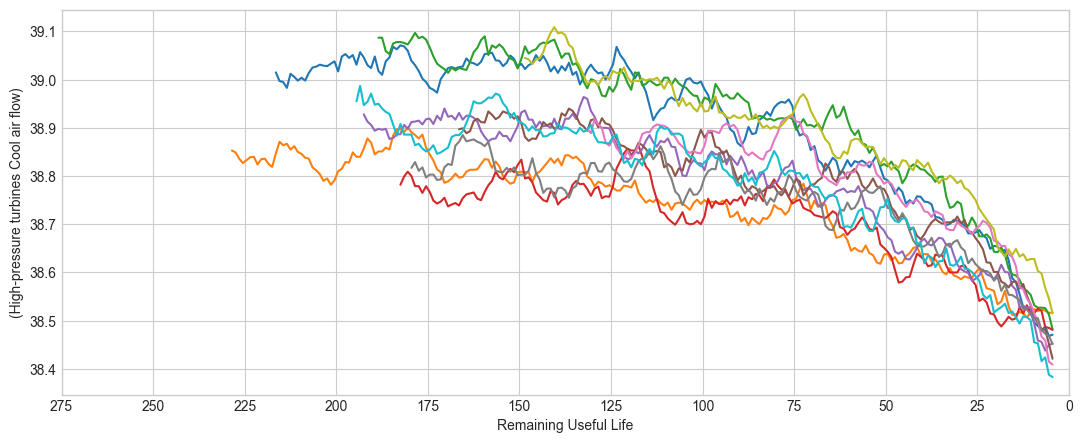

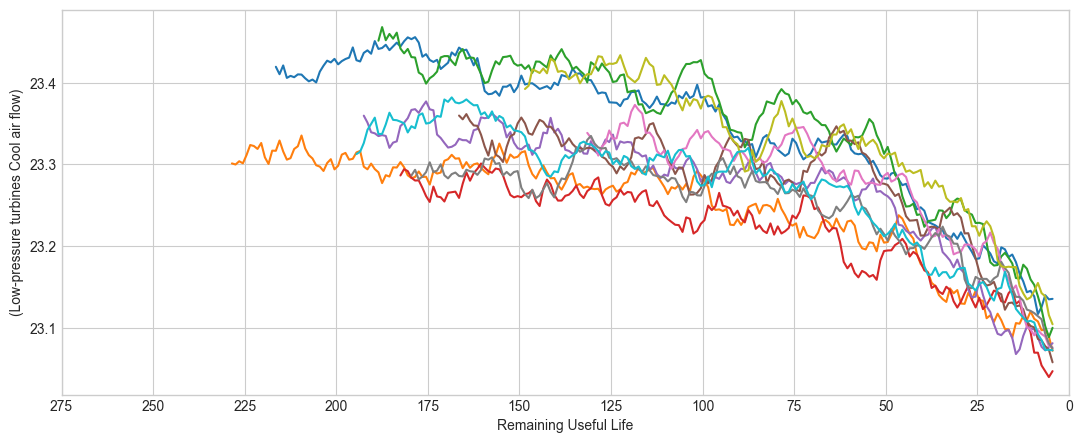

In [37]:
for i in range(1, 22):
    try:
        plot_signal(train, Sensor_dictionary, 's_'+str(i))
    except:
        pass

- 상수형태의 값은 버린다.

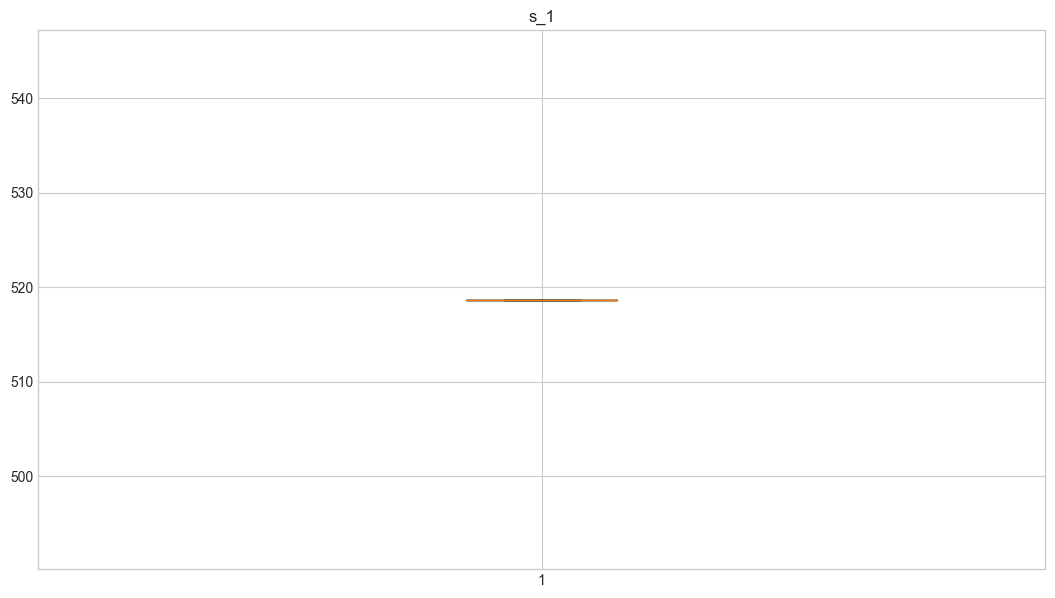

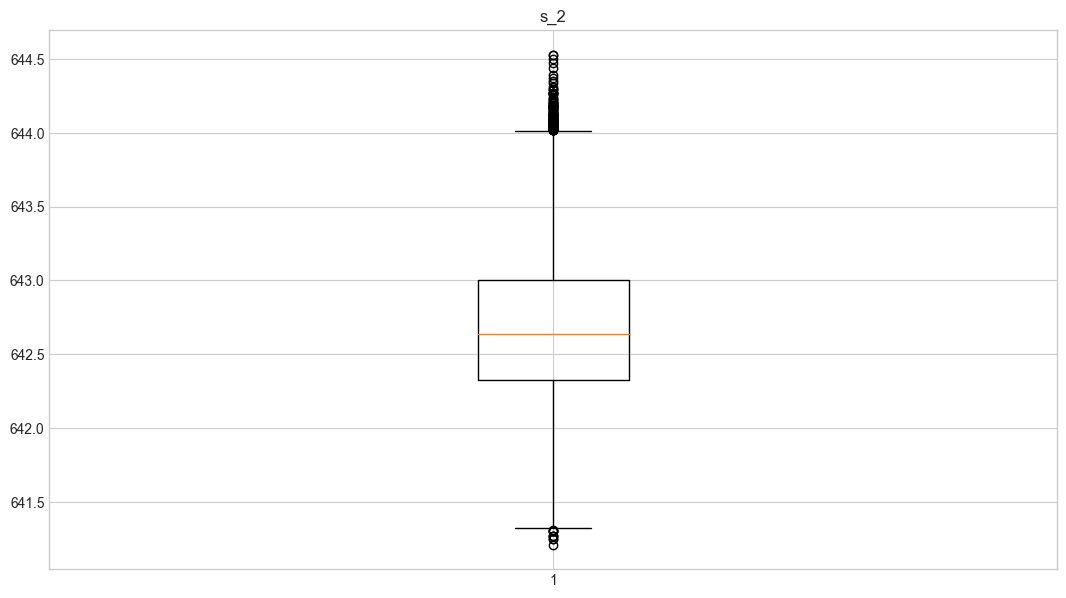

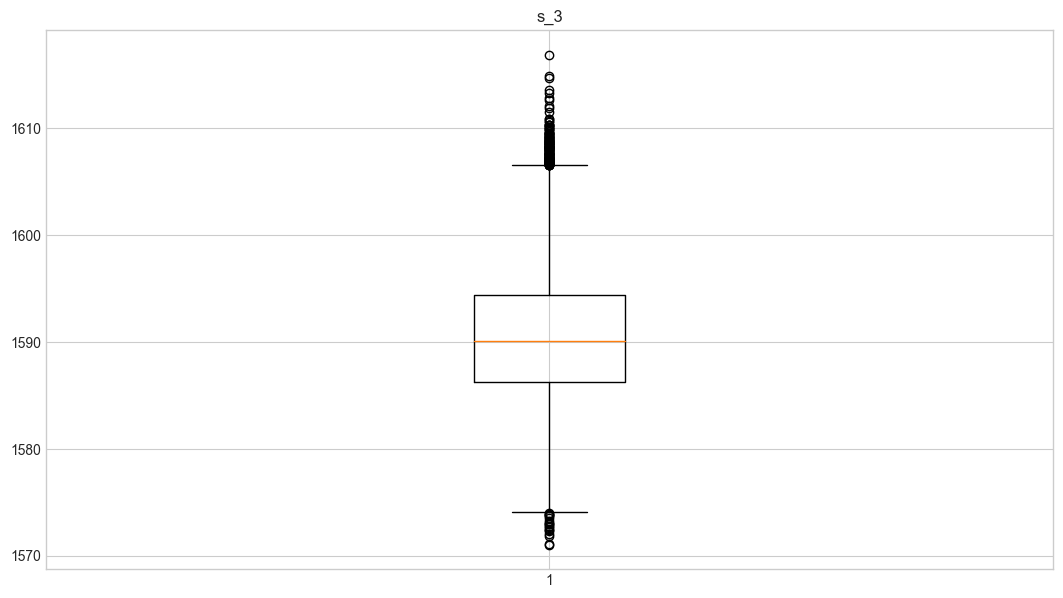

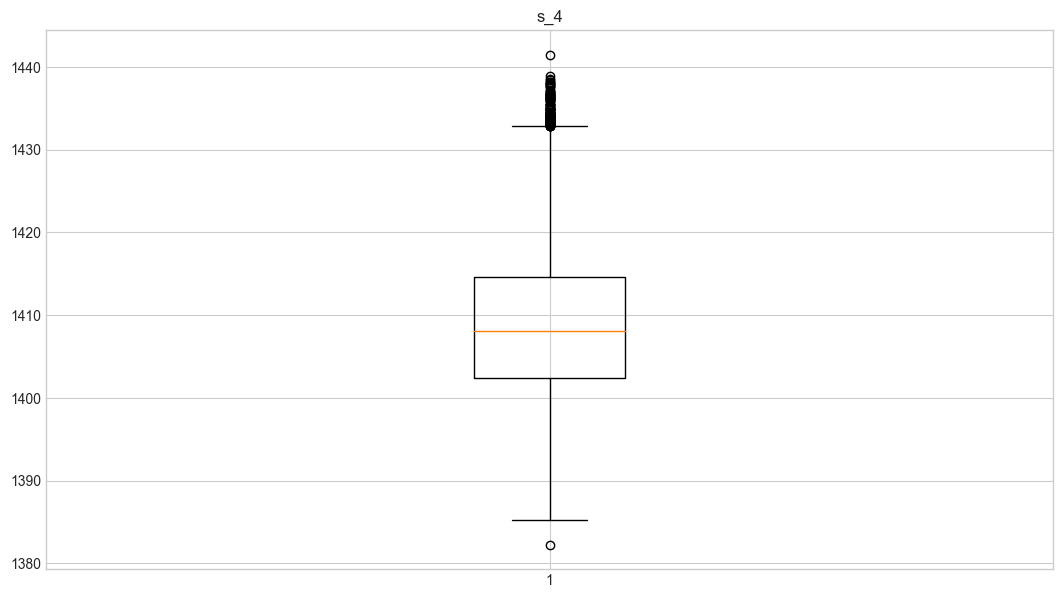

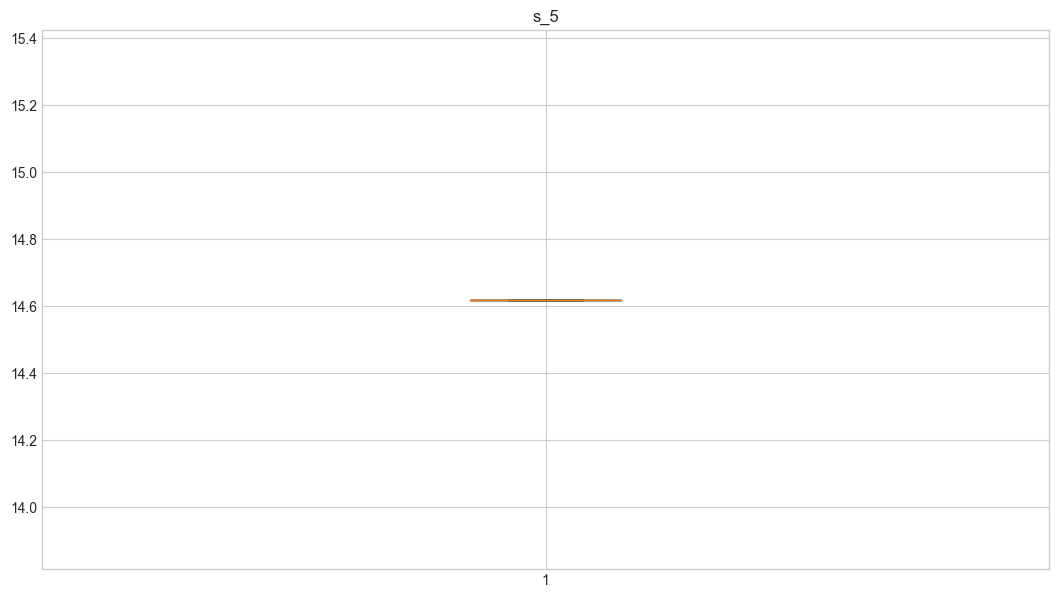

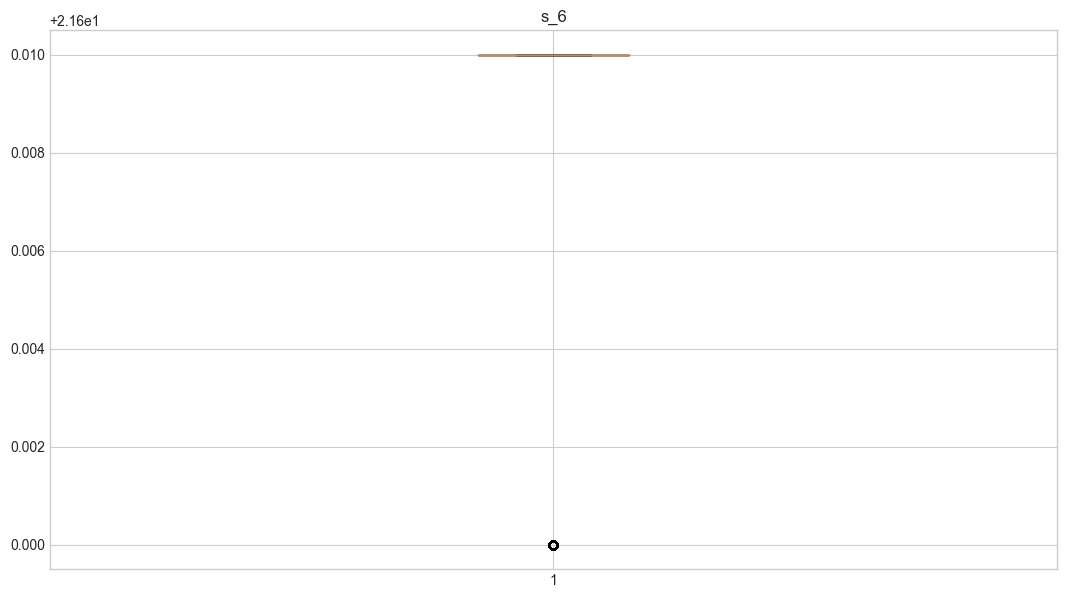

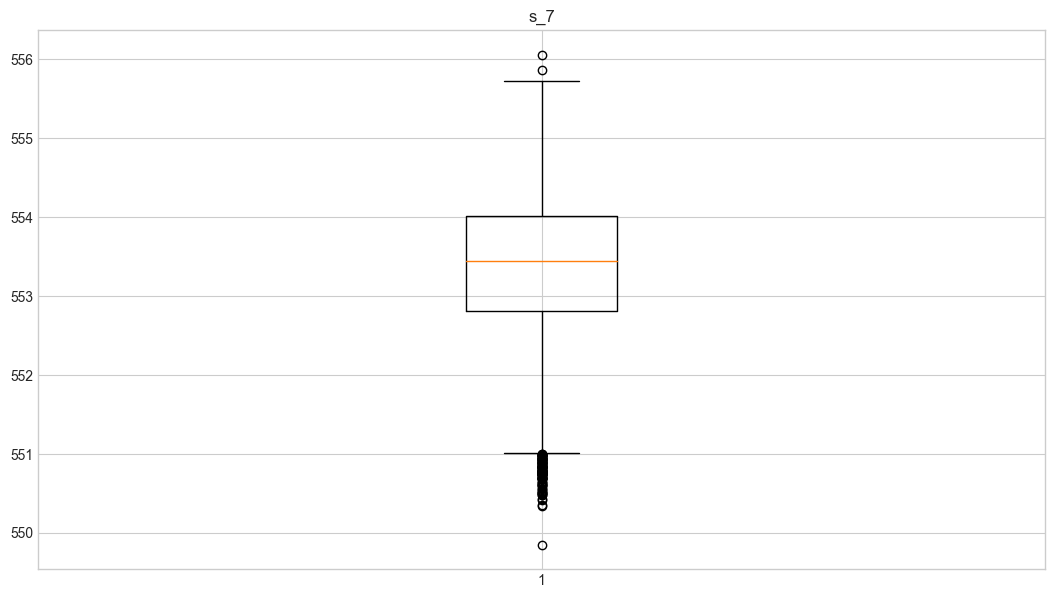

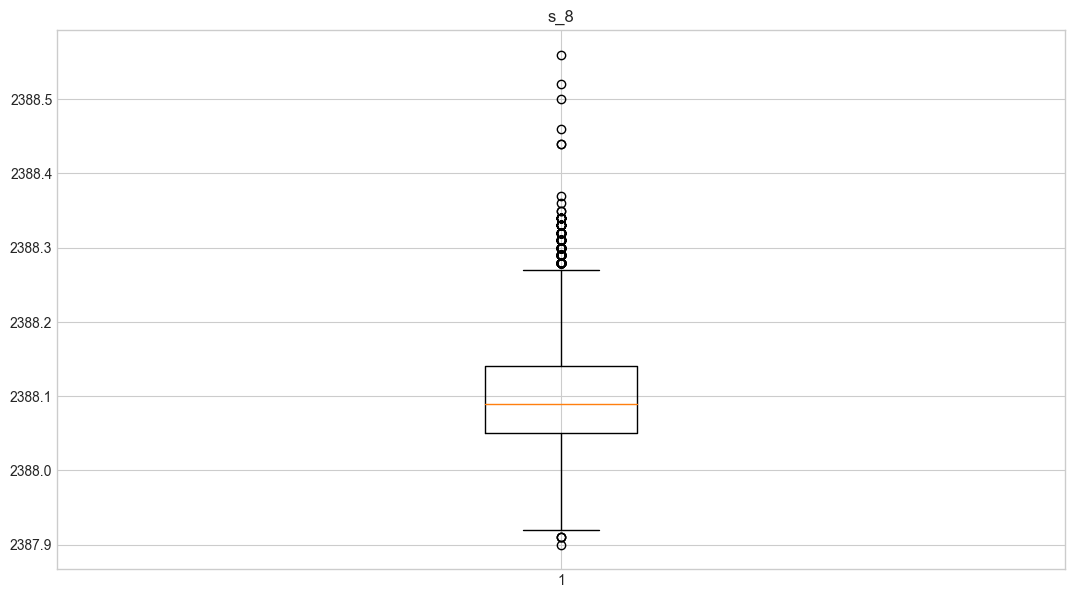

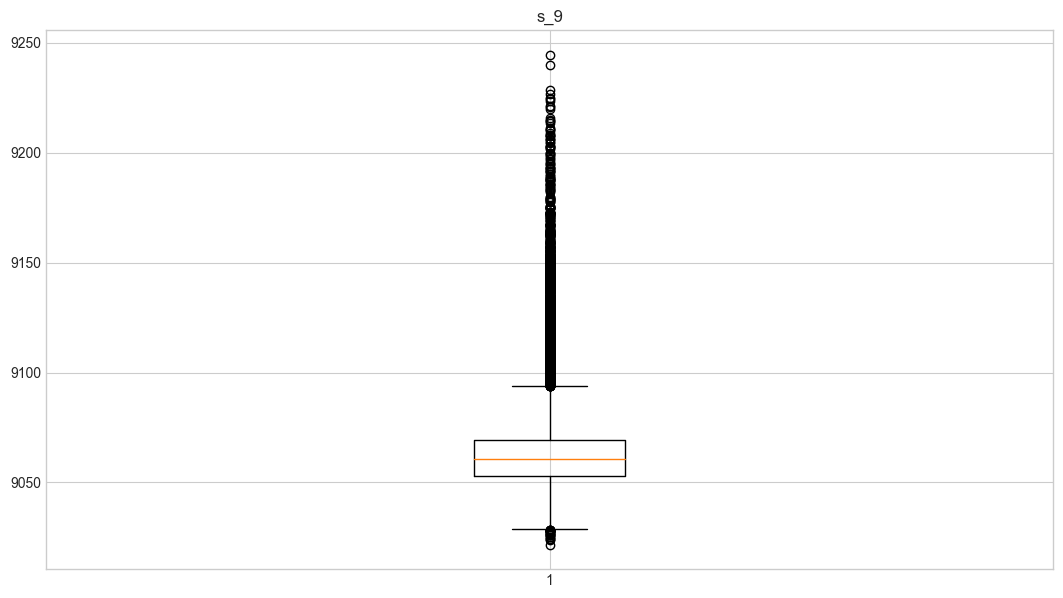

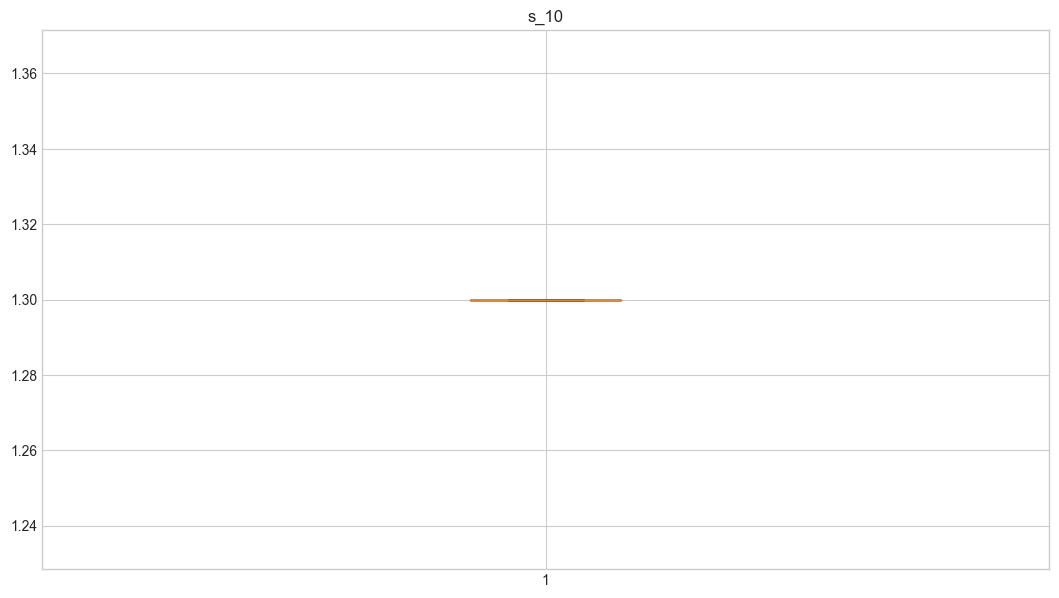

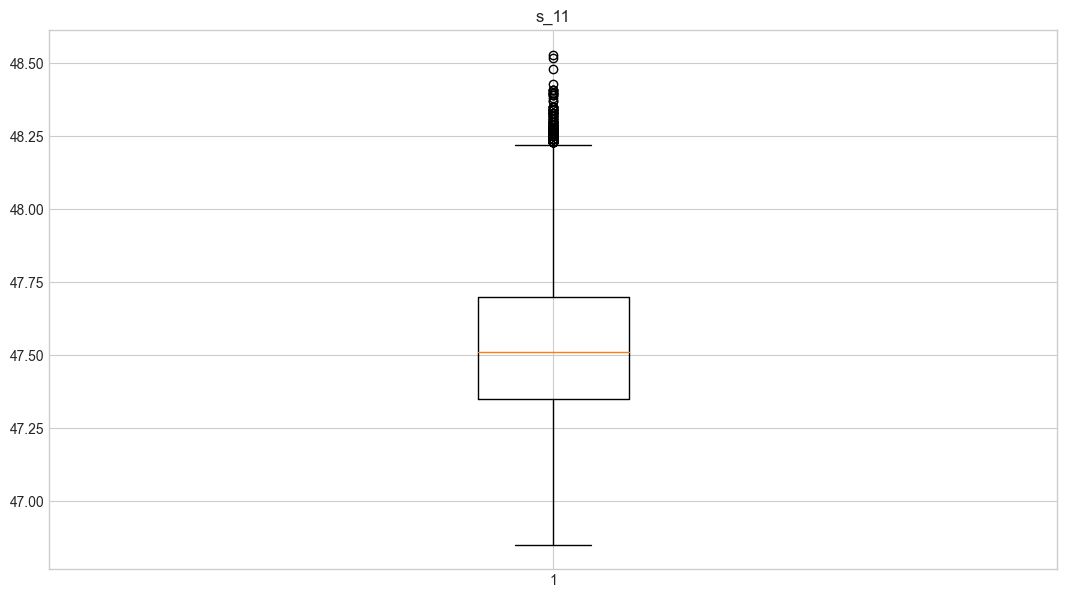

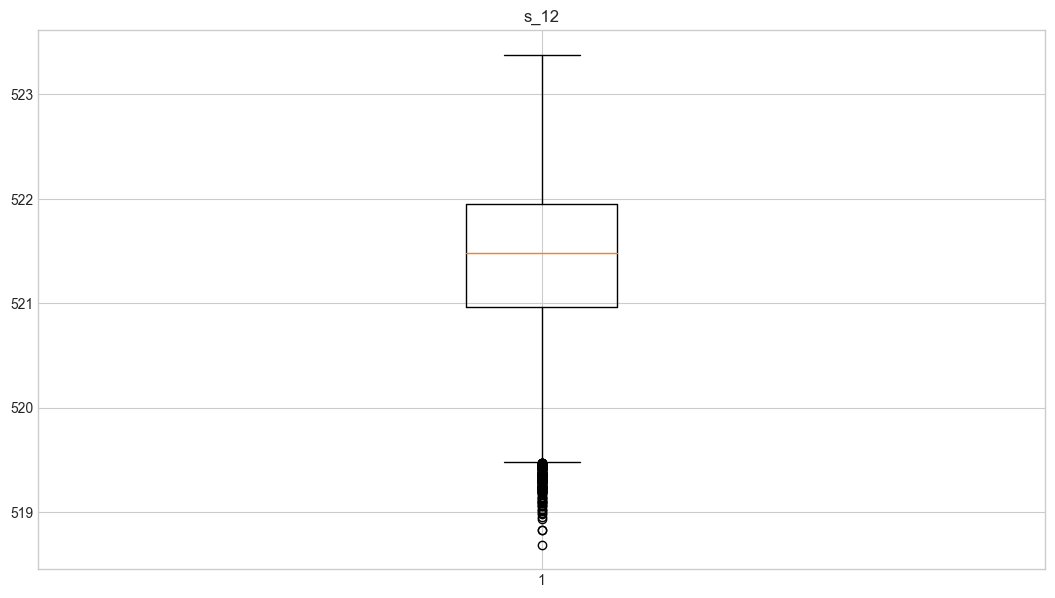

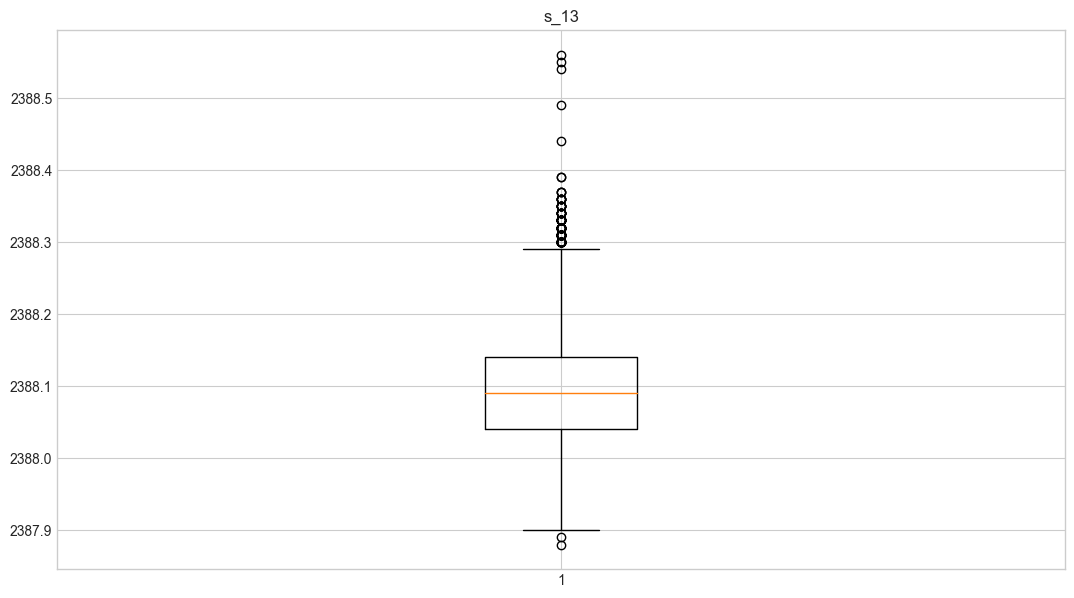

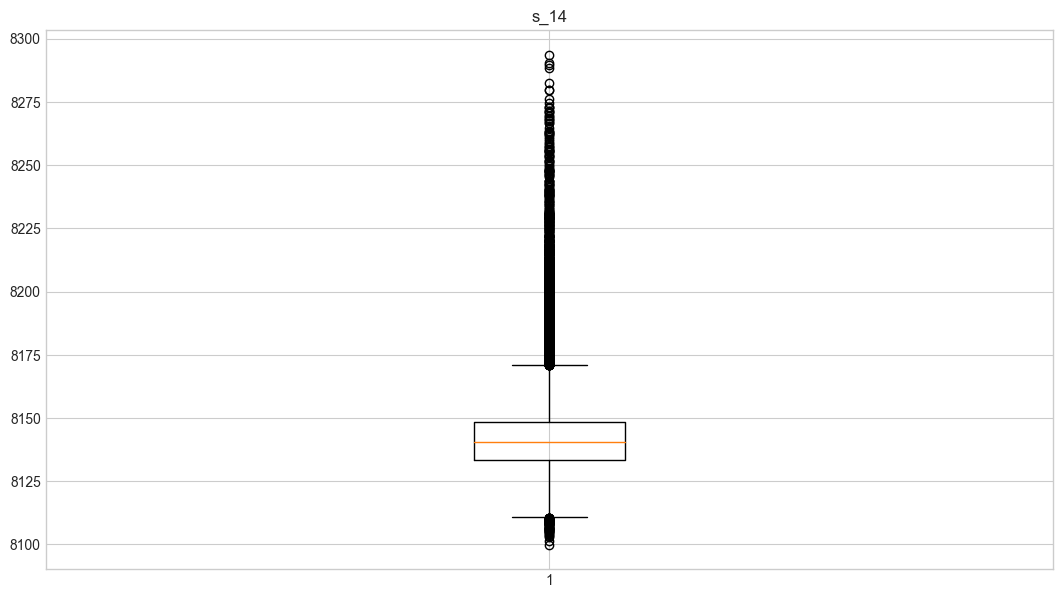

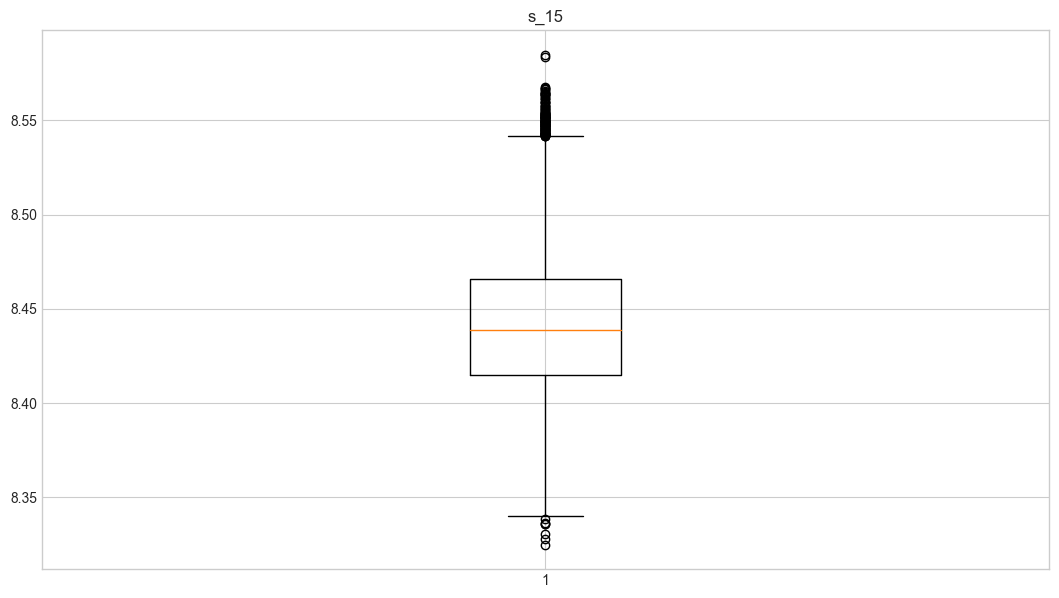

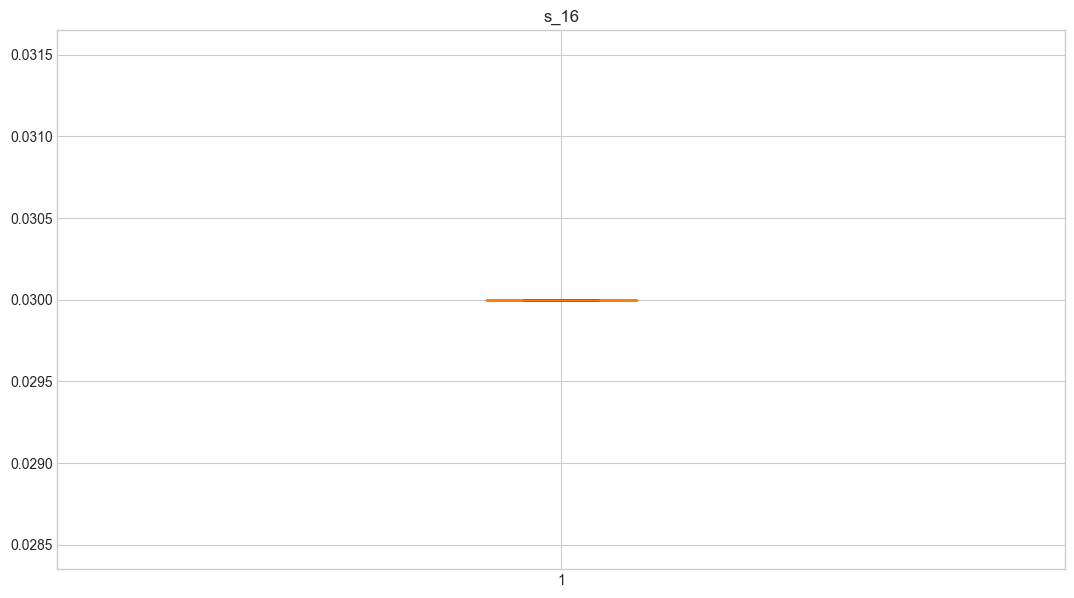

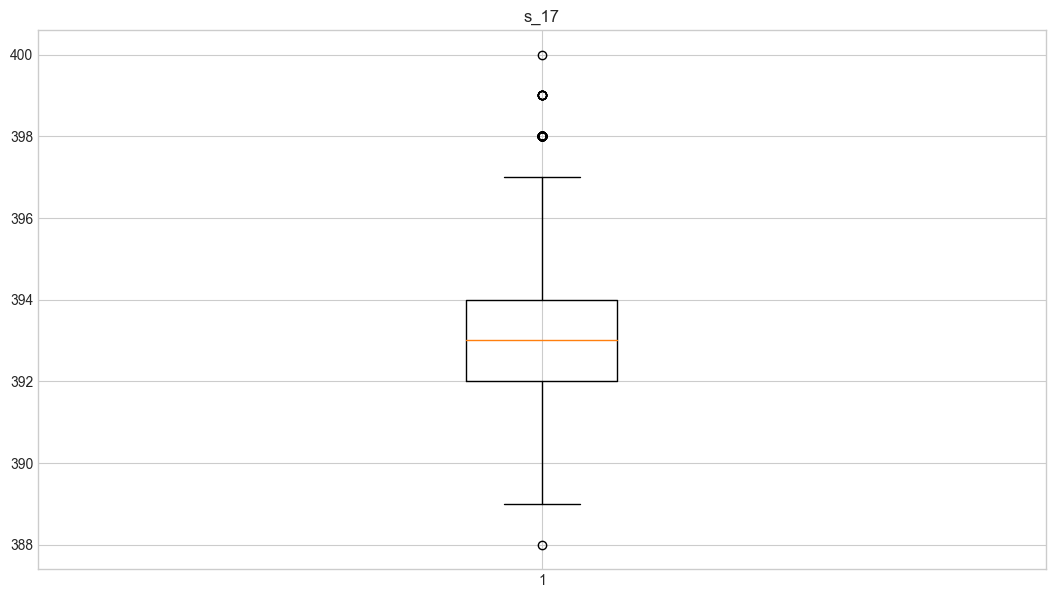

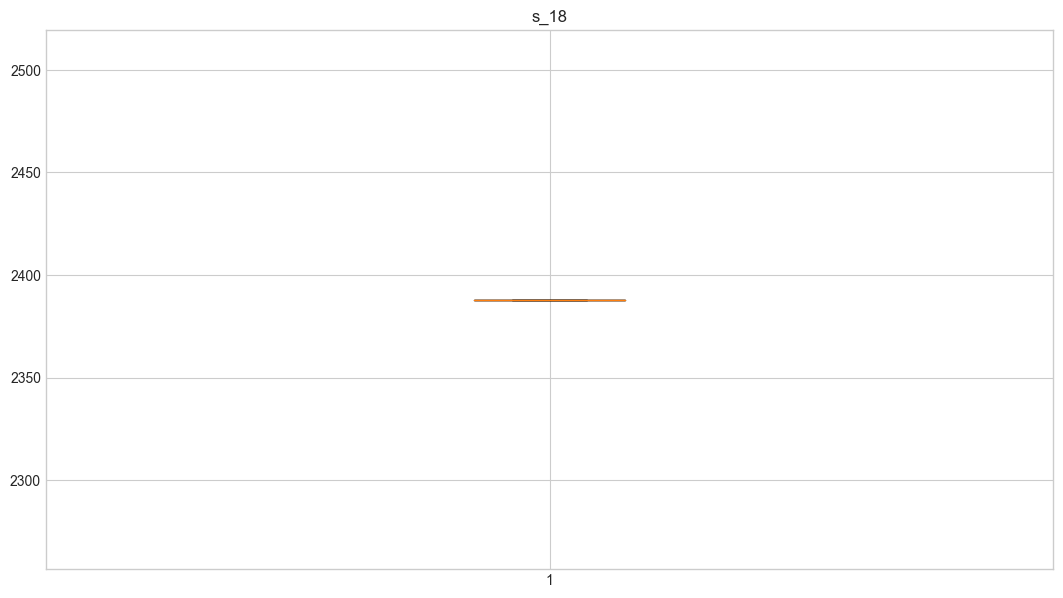

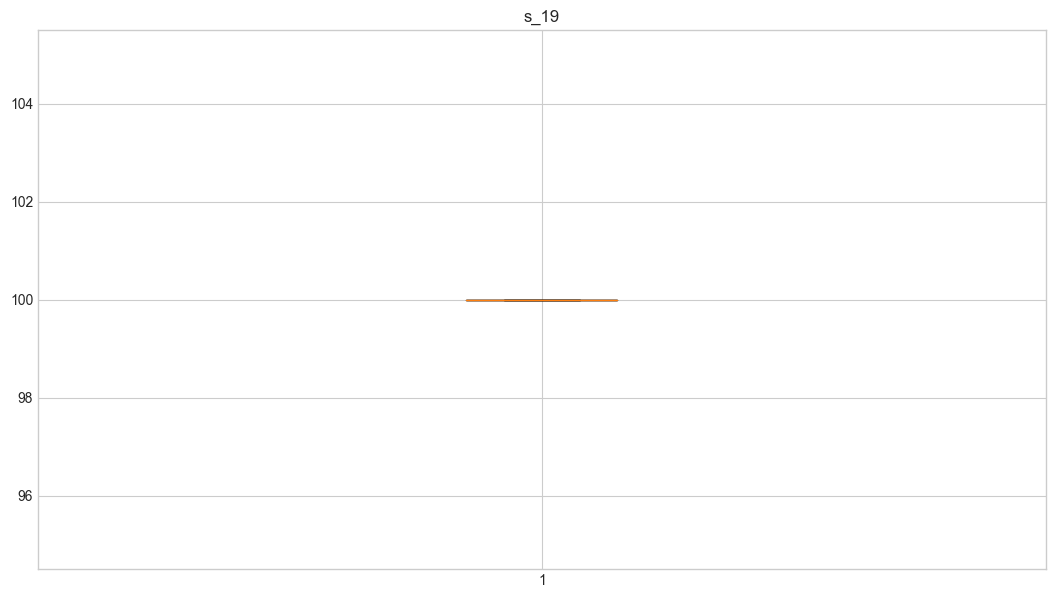

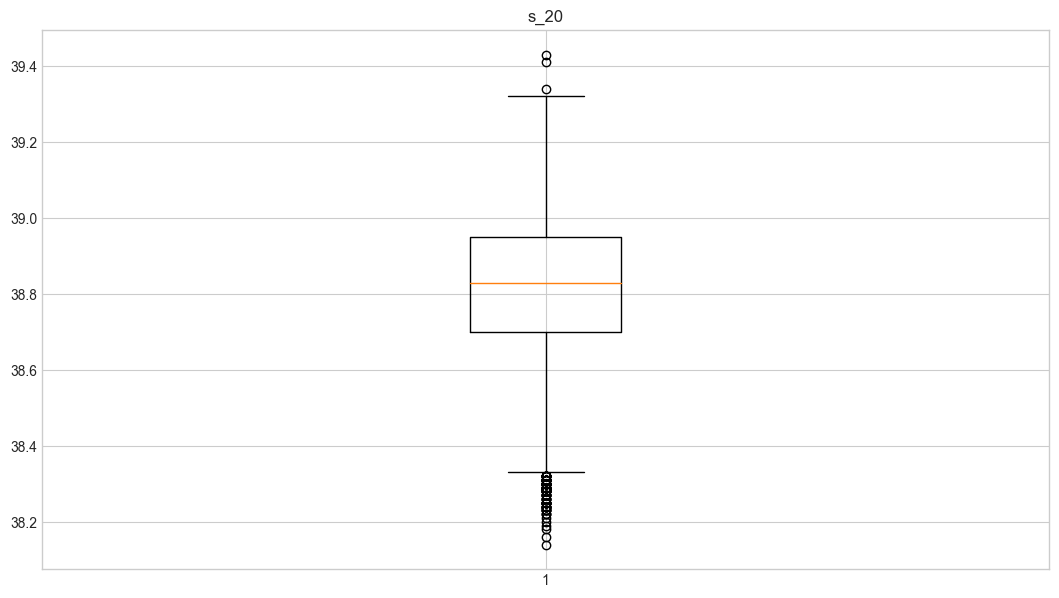

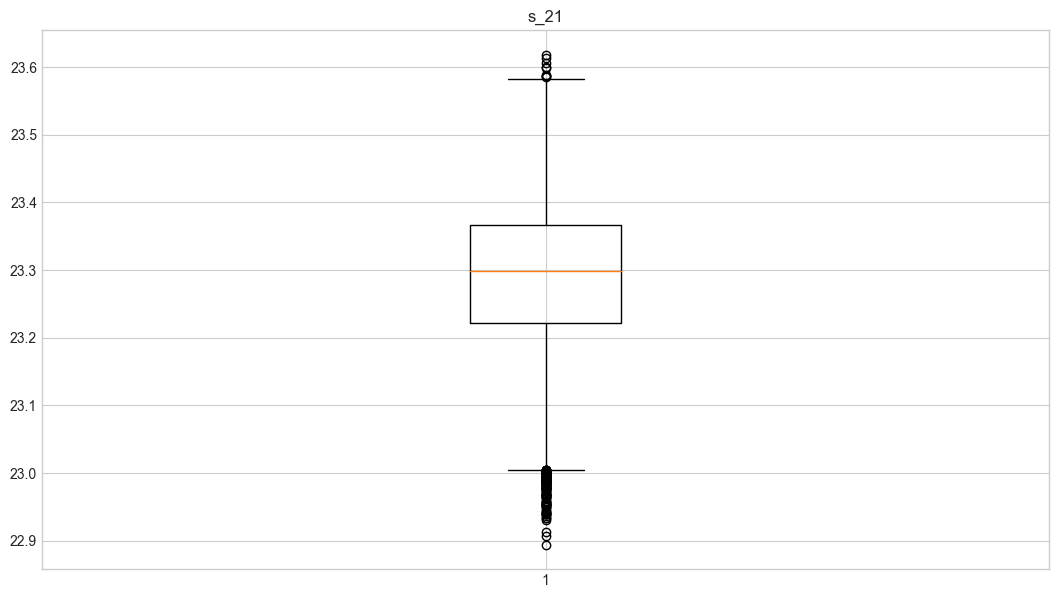

In [38]:
for x in sensor_names:
    plt.figure(figsize=(13,7))
    plt.boxplot(train[x])
    plt.title(x)
    plt.show()


- 1,5,10,16,18,19는 상수
- 일부 피처는 분포가 양호하지 않고, outlier가 많다.

In [39]:
train.loc[:, 's_1':].describe().transpose()

count         mean           std        min        25%        50%  \
s_1   20631.0   518.670000  6.537152e-11   518.6700   518.6700   518.6700   
s_2   20631.0   642.680934  5.000533e-01   641.2100   642.3250   642.6400   
s_3   20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600  1590.1000   
s_4   20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600  1408.0400   
s_5   20631.0    14.620000  3.394700e-12    14.6200    14.6200    14.6200   
s_6   20631.0    21.609803  1.388985e-03    21.6000    21.6100    21.6100   
s_7   20631.0   553.367711  8.850923e-01   549.8500   552.8100   553.4400   
s_8   20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500  2388.0900   
s_9   20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000  9060.6600   
s_10  20631.0     1.300000  4.660829e-13     1.3000     1.3000     1.3000   
s_11  20631.0    47.541168  2.670874e-01    46.8500    47.3500    47.5100   
s_12  20631.0   521.413470  7.375534e-01   518.6900   520.9600   521.4800   
s_13  20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400  2388.0900   
s_14  20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450  8140.5400   
s_15  20631.0     8.442146  3.750504e-02     8.3249     8.4149     8.4389   
s_16  20631.0     0.030000  1.556432e-14     0.0300     0.0300     0.0300   
s_17  20631.0   393.210654  1.548763e+00   388.0000   392.0000   393.0000   
s_18  20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000   
s_19  20631.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
s_20  20631.0    38.816271  1.807464e-01    38.1400    38.7000    38.8300   
s_21  20631.0    23.289705  1.082509e-01    22.8942    23.2218    23.2979   
RUL   20631.0   107.807862  6.888099e+01     0.0000    51.0000   103.0000   

            75%        max  
s_1    518.6700   518.6700  
s_2    643.0000   644.5300  
s_3   1594.3800  1616.9100  
s_4   1414.5550  1441.4900  
s_5     14.6200    14.6200  
s_6     21.6100    21.6100  
s_7    554.0100   556.0600  
s_8   2388.1400  2388.5600  
s_9   9069.4200  9244.5900  
s_10     1.3000     1.3000  
s_11    47.7000    48.5300  
s_12   521.9500   523.3800  
s_13  2388.1400  2388.5600  
s_14  8148.3100  8293.7200  
s_15     8.4656     8.5848  
s_16     0.0300     0.0300  
s_17   394.0000   400.0000  
s_18  2388.0000  2388.0000  
s_19   100.0000   100.0000  
s_20    38.9500    39.4300  
s_21    23.3668    23.6184  
RUL    155.0000   361.0000

불필요한 컬럼 제거 및 데이터 분리

In [49]:
from sklearn.model_selection import train_test_split

drop_labels = index_names + setting_names

X_train = train.drop(columns=drop_labels).copy()
X_train, X_test, y_train, y_test = train_test_split(
    X_train, X_train["RUL"], test_size=0.3, random_state=42
)

스케일링

In [51]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = X_train.drop(columns=["RUL"])
X_test = X_test.drop(columns=["RUL"])

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

# Conserve only the last occurence of each unit to match the length of y_valid
X_valid = valid.groupby("unit_number").last().reset_index().drop(columns=drop_labels)
# scaling X_valid
X_valid_s = scaler.fit_transform(X_valid)

In [52]:
print(X_valid_s.shape)
print(y_valid.shape)

(100, 21)
(100, 1)


plotting featurs

array([[<Axes: title={'center': 's_2'}>, <Axes: title={'center': 's_3'}>,
        <Axes: title={'center': 's_4'}>, <Axes: title={'center': 's_7'}>],
       [<Axes: title={'center': 's_8'}>, <Axes: title={'center': 's_9'}>,
        <Axes: title={'center': 's_11'}>,
        <Axes: title={'center': 's_12'}>],
       [<Axes: title={'center': 's_13'}>,
        <Axes: title={'center': 's_14'}>,
        <Axes: title={'center': 's_15'}>,
        <Axes: title={'center': 's_17'}>],
       [<Axes: title={'center': 's_20'}>,
        <Axes: title={'center': 's_21'}>, <Axes: >, <Axes: >]],
      dtype=object)

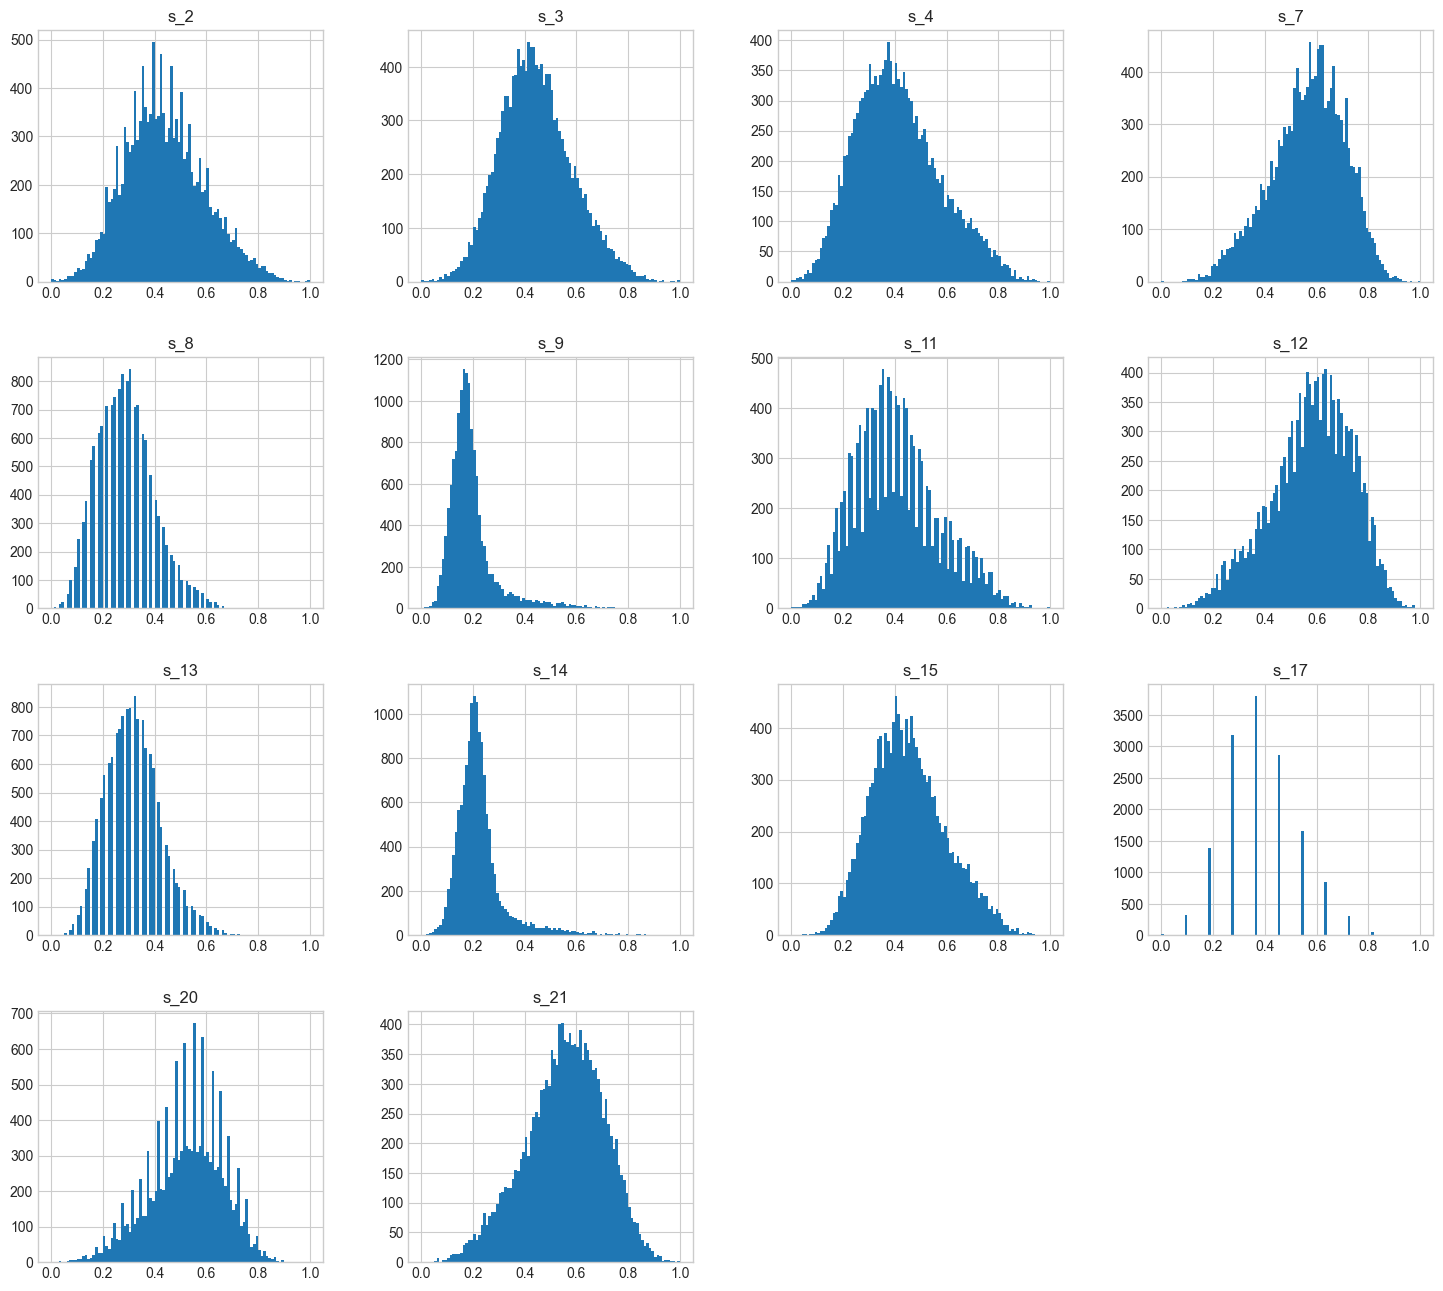

In [53]:
sensor_names = [
    "s_{}".format(i) for i in range(1, 22) if i not in [1, 5, 6, 10, 16, 18, 19]
]
pd.DataFrame(X_train_s, columns=["s_{}".format(i) for i in range(1, 22)])[
    sensor_names
].hist(bins=100, figsize=(18, 16))

### Models Implementaion and instantiation

In [61]:
class Linear_Regression():
    def __init__(self, lr=0.01, iterations = 150):
        self.lr = lr
        self.iterations = iterations
        
    def fit(self, X, y):
        self.l, self.p = X.shape
        self.W = np.zeros(self.p)
        self.b = 0
        self.X = X
        self.y = y
        
        for i in range( self.iterations ) :  
            self.weight_updater()
        return self
         
    def weight_updater( self ) :
        Y_pred = self.predict( self.X )  
        #  gradients  
        dW = - ( 2 * ( self.X.T ).dot( self.y - Y_pred )  ) / self.l
        db = - 2 * np.sum( self.y - Y_pred ) / self.l
        # new weights assigned
        self.b = self.b - self.lr * db
        self.W = self.W - self.lr * dW
        return self
          
    def predict( self, X ) :
          # Y_pr=X.W+b
        return X.dot( self.W ) + self.b

In [62]:
from sklearn.svm import SVR
regressor = SVR(kernel='rbf')

In [63]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)

평가함수 정의

In [64]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [65]:
def plot_predActual(y_test, y_test_hat):
  
    indices = np.arange(len(y_test_hat))
    wth= 0.6
    plt.figure(figsize=(70,30))
    true_values = [int(x) for x in y_test.values]
    predicted_values = list(y_test_hat)

    plt.bar(indices, true_values, width=wth,color='b', label='True RUL')
    plt.bar([i for i in indices], predicted_values, width=0.5*wth, color='r', alpha=0.7, label='Predicted RUL')

    plt.legend(prop={'size': 40})
    plt.tick_params(labelsize=40)

    plt.show()

### 첫번째 시도 : all features, without historical data

Linear regression

In [66]:
lr=Linear_Regression() #Instantiation
lr.fit(X=X_train_s, y=y_train) #Fitting 

y_lr_train = lr.predict(X_train_s) #Prediction on train data
evaluate(y_train,y_lr_train, label='train')

y_lr_test = lr.predict(X_test_s)  #Prediction on test data
evaluate(y_test, y_lr_test, label='test')

y_lr_valid= lr.predict(X_valid_s) #Prediction on validation data
evaluate(y_valid, y_lr_valid, label='valid')

train set RMSE:56.19869318681088, R2:0.3439361345919162
test set RMSE:54.264009074691856, R2:0.35713062175493715
valid set RMSE:34.849622282235096, R2:0.2967064952591342


SVR

In [67]:
regressor.fit(X_train_s, y_train) # fitting

y_svr_train = regressor.predict(X_train_s) #Prediction on train data
evaluate(y_train,y_svr_train, label='train')

y_svr_test = regressor.predict(X_test_s) #Prediction on test data
evaluate(y_test, y_svr_test, label='test')

y_svr_valid= lr.predict(X_valid_s)  #Prediction on validation data
evaluate(y_valid, y_svr_valid, label='valid')


train set RMSE:43.56448464126648, R2:0.605761670162996
test set RMSE:47.26718449996111, R2:0.5122262167433573
valid set RMSE:34.849622282235096, R2:0.2967064952591342


Random forest 

In [68]:
# gridsearch goes here
rf.fit(X_train_s, y_train)
# predict and evaluate
y_rf_train = rf.predict(X_train_s)
evaluate(y_train,y_rf_train, label='train')

y_rf_test = rf.predict(X_test_s)
evaluate(y_test, y_rf_test, label='test')

y_rf_valid = rf.predict(X_valid_s)
evaluate(y_valid, y_rf_valid, label='valid')

train set RMSE:15.408303170220156, R2:0.9506822432050425
test set RMSE:44.36383009860364, R2:0.5703082128383993
valid set RMSE:30.653618024631285, R2:0.45586841183607596


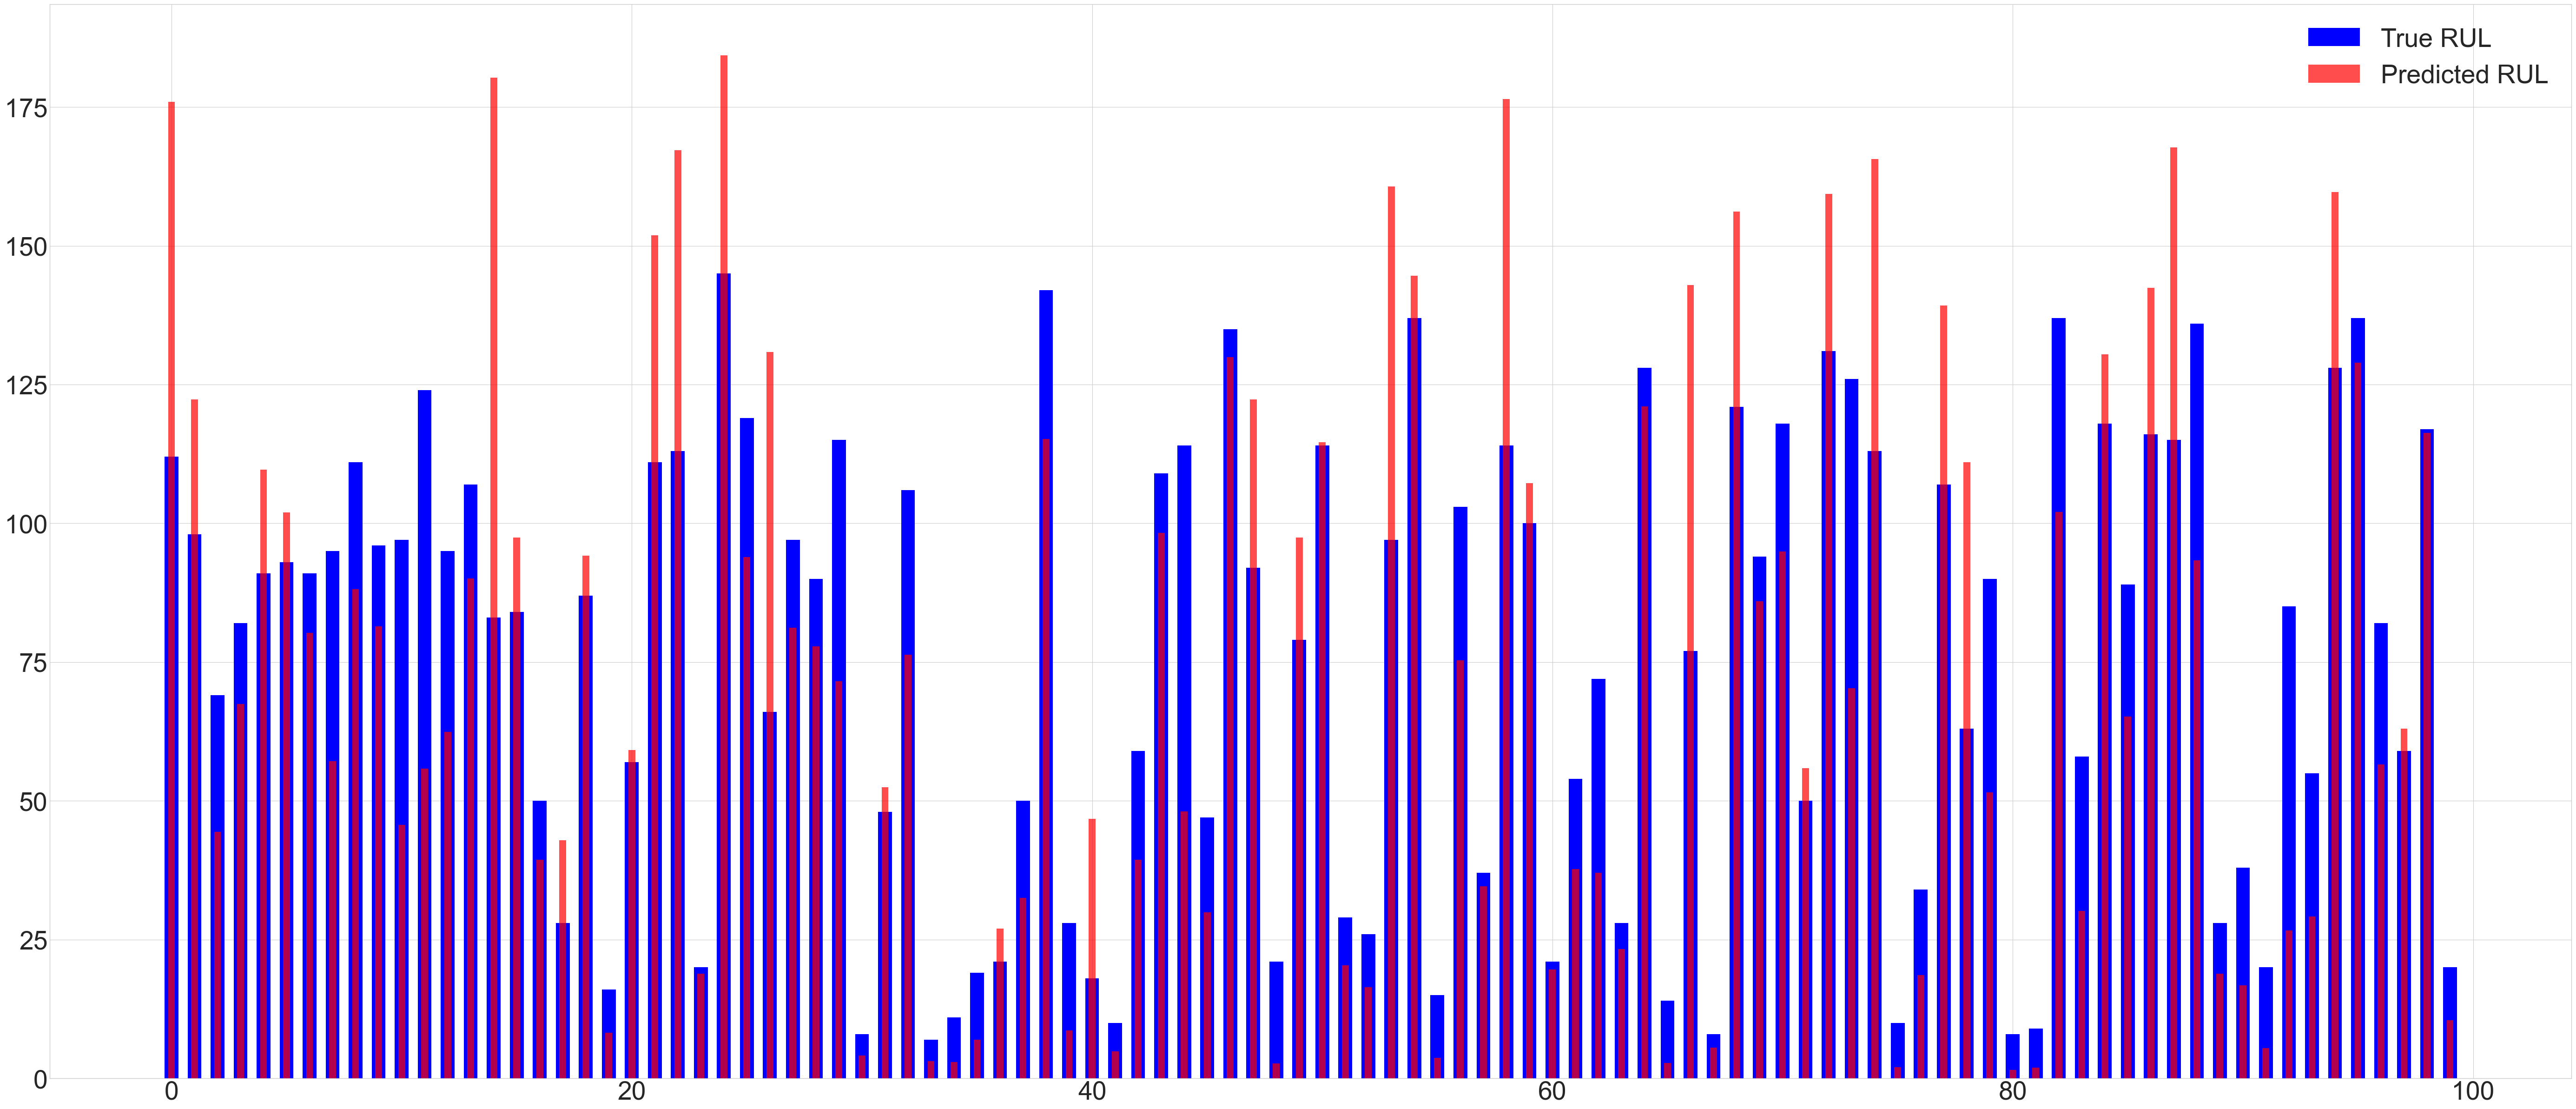

In [69]:
plot_predActual(y_valid, y_rf_valid)

- 모델이 RUL을 과도하게 큰 값으로 예측하는 경향이 있다.

### 2nd attempt (Data without useless sensors, without historical data)

이 섹션에서는 상수 신호를 드롭하고, max_time_cycles 플롯에서 대부분의 경우 최대값이 [190,210] 간격에 있음을 확인했으므로 RUL 클리핑을 통해 최대 RUL을 195로 설정하겠습니다,

195보다 높은 모든 RUL은 195와 동일하다는 점을 고려하면 195는 이미 높은 RUL이므로 주요 목표에 영향을 주지 않으면서 오버헤드를 줄일 수 있으므로 예측 프로세스에 도움이 됩니다.

In [70]:
print('maximum of y_train : ',y_train.max())
print('maximum of y_test : ',y_test.max())
print('maximum of y_valid : ',y_valid.max())

maximum of y_train :  361
maximum of y_test :  360
maximum of y_valid :  RUL    145
dtype: int64


(array([1023., 1066., 1083., 1120.,  937.,  557.,  237.,  117.,   35.,
          15.]),
 array([  0.,  36.,  72., 108., 144., 180., 216., 252., 288., 324., 360.]),
 <BarContainer object of 10 artists>)

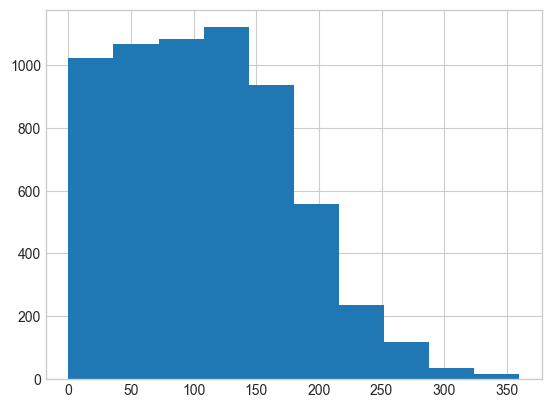

In [71]:
plt.hist(y_test)

In [72]:
drop_labels2=['s_1', 's_5','s_6','s_10',  's_16', 's_18', 's_19']
X_train_2=X_train.drop(columns=drop_labels2, axis=1) # drop the constant columns from the train dataset
X_test_2=X_test.drop(columns=drop_labels2, axis=1)  # drop the constant columns from the test dataset
X_train_2_s=scaler.fit_transform(X_train_2) #scaling X_train_2
X_test_2_s=scaler.fit_transform(X_test_2) #scaling X_test_2
y_train_clip=y_train.clip(upper=195)  #Clipping y_train to have 195 as the maximum value 
X_valid_2=X_valid.drop(columns=drop_labels2, axis=1)  # drop the constant columns from the validation dataset
X_valid_2_s=scaler.fit_transform(X_valid_2) #scaling X_valid_2

Linear Regression

In [73]:
lr=Linear_Regression()
lr.fit(X=X_train_2_s, y=y_train_clip)

y_lr_train = lr.predict(X_train_2_s)
evaluate(y_train_clip,y_lr_train, label='train')

y_lr_test = lr.predict(X_test_2_s)
evaluate(y_test, y_lr_test, label='test')

y_lr_valid = lr.predict(X_valid_2_s)
evaluate(y_valid, y_lr_valid, label='valid')

train set RMSE:47.86312955545103, R2:0.3792662465007206
test set RMSE:55.626100239704606, R2:0.3244519972933423
valid set RMSE:34.21070108960351, R2:0.3222579927041399


svr

In [74]:
regressor.fit(X_train_2_s, y_train)

y_svr_train = regressor.predict(X_train_2_s)
evaluate(y_train_clip,y_svr_train, label='train')

y_svr_test = regressor.predict(X_test_2_s)
evaluate(y_test, y_svr_test, label='test')

y_svr_valid = regressor.predict(X_valid_2_s)
evaluate(y_valid, y_svr_valid, label='valid')


train set RMSE:32.91543148706822, R2:0.7064363470171213
test set RMSE:48.75516379159361, R2:0.48103242301470384
valid set RMSE:25.947912225366213, R2:0.6101071274546095


random foreset

In [75]:
rf.fit(X_train_2_s, y_train_clip)
# predict and evaluate
y_rf_train = rf.predict(X_train_2_s)
evaluate(y_train_clip,y_rf_train, label='train')

y_rf_test = rf.predict(X_test_2_s)
evaluate(y_test, y_rf_test, label='test')

y_rf_valid = rf.predict(X_valid_2_s)
evaluate(y_valid, y_rf_valid, label='valid')

train set RMSE:12.036862499525814, R2:0.9607418547981479
test set RMSE:45.81838291793876, R2:0.5416697719315231
valid set RMSE:26.548403567823055, R2:0.5918523714819


In [76]:
import xgboost
xgb = xgboost.XGBRegressor(n_estimators=110, learning_rate=0.02, gamma=0, subsample=0.8,colsample_bytree=0.5, max_depth=3)
xgb.fit(X_train_2_s, y_train_clip)


y_xgb_train = xgb.predict(X_train_2_s)
evaluate(y_train_clip,y_xgb_train, label='train')

y_xgb_test = xgb.predict(X_test_2_s)
evaluate(y_test, y_xgb_test, label='test')

y_xgb_valid = xgb.predict(X_valid_2_s)
evaluate(y_valid, y_xgb_valid, label='valid')

train set RMSE:35.68788910609097, R2:0.65490004751721
test set RMSE:49.90822638411164, R2:0.45619492168301223
valid set RMSE:25.920851695881066, R2:0.6109199254883747


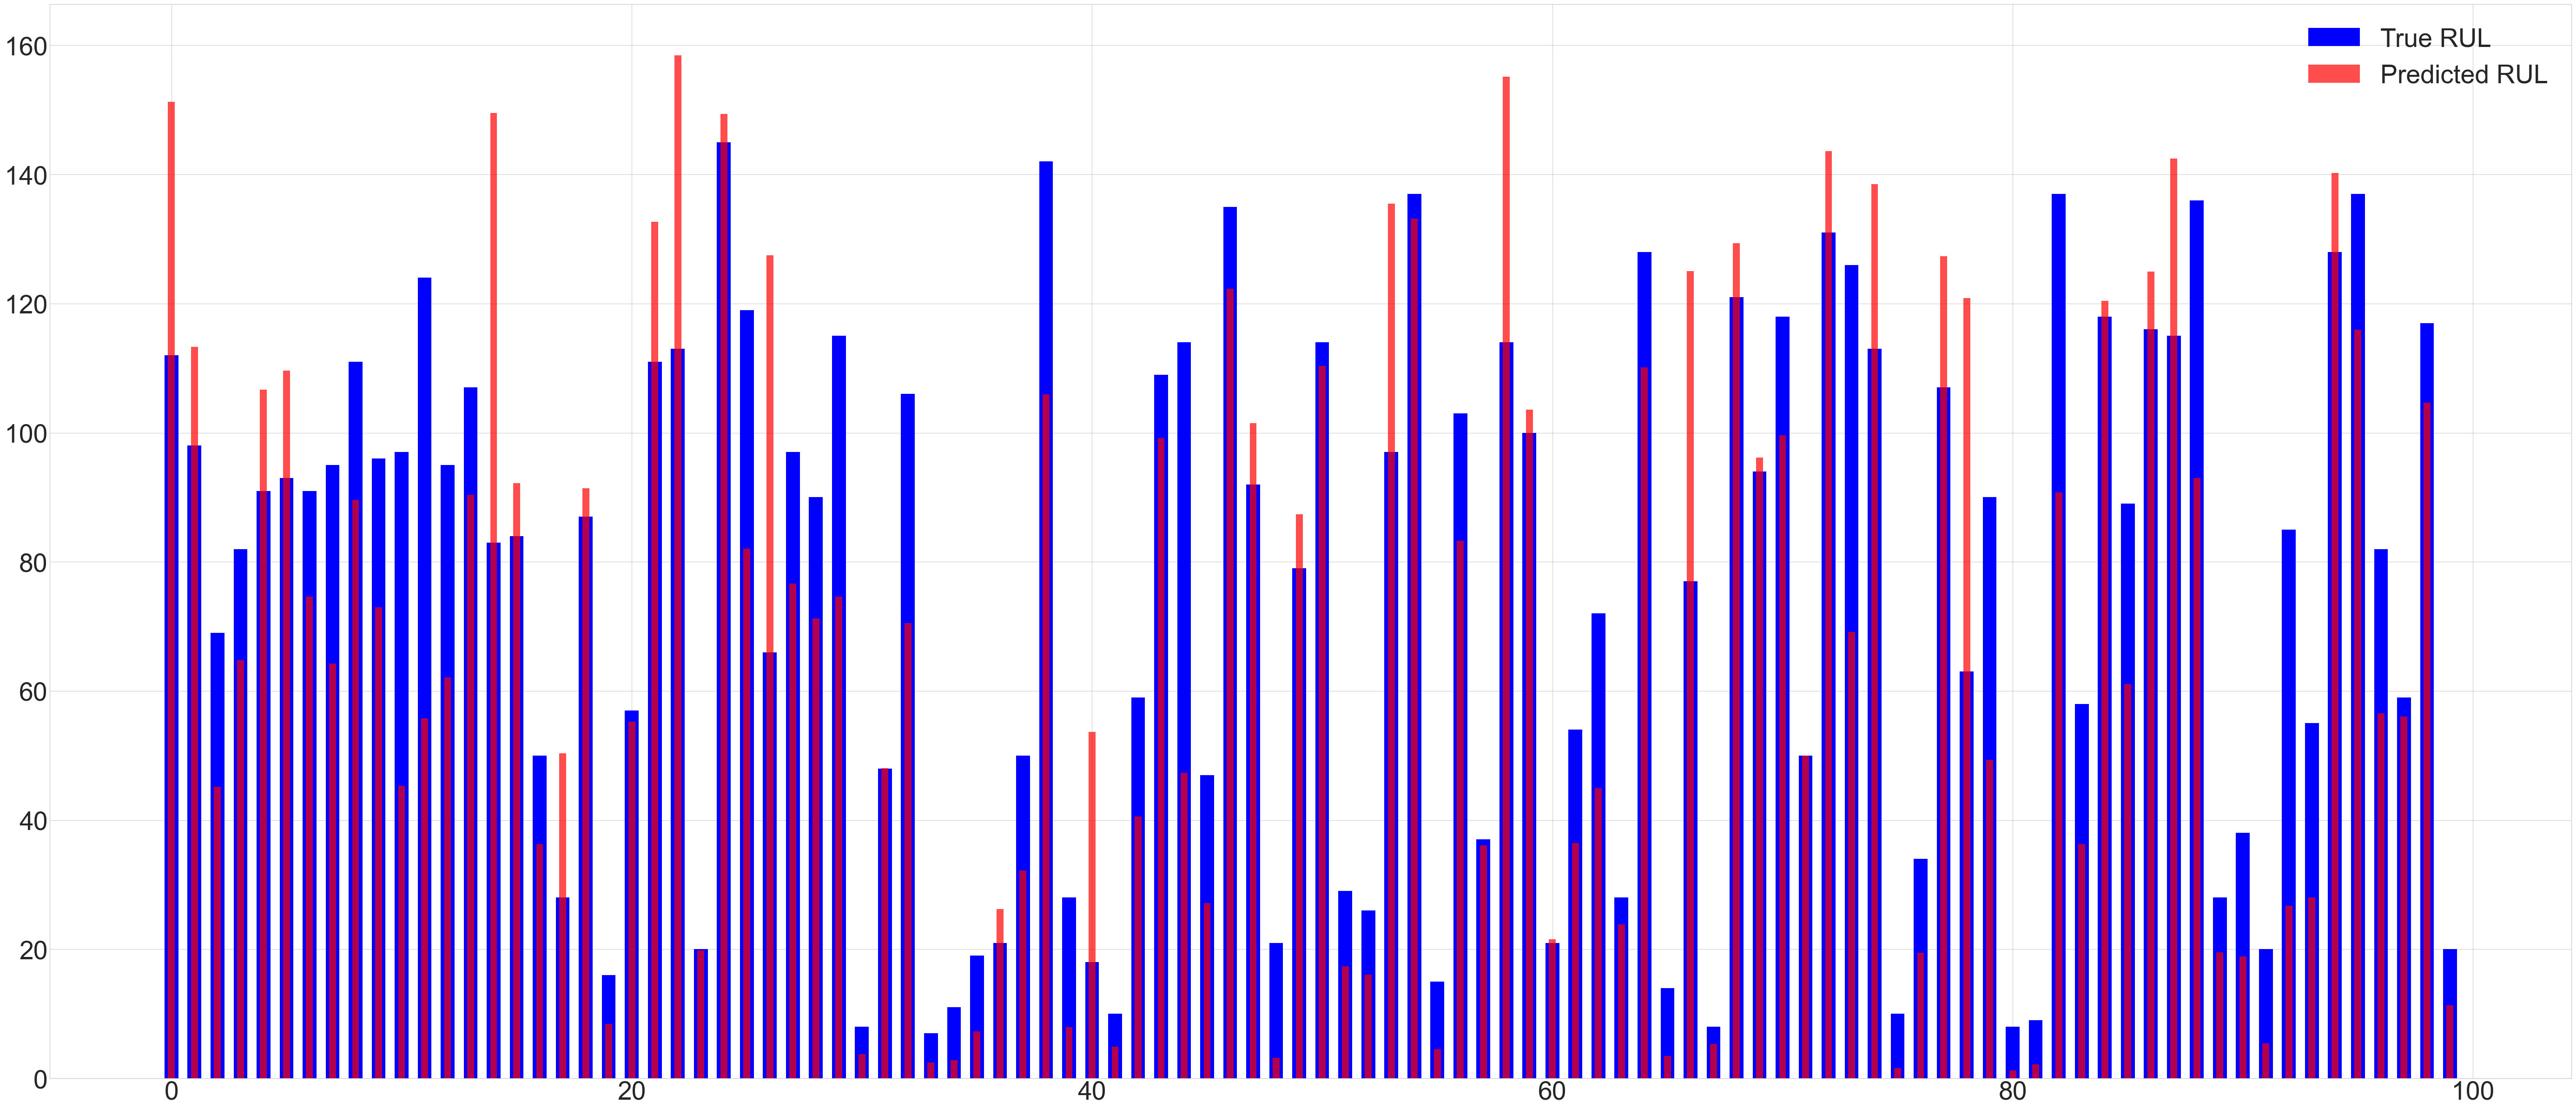

In [77]:
plot_predActual(y_valid, y_rf_valid)

### 3rd attempt (Data without useless sensors, with historical data)

이 섹션에서는 '롤링 평균 피처'라는 새로운 피처를 데이터에 추가하면서 피처에서 시계열 패턴을 발견하려고 합니다. 이는 10번의 시간 주기를 고려한 피처의 평균값에 해당합니다. 모든 피처에 대해 계산됩니다.

In [78]:
df=train.copy()
for x in X_train_2.columns:
    df[x+'_rm']=0

    
df.columns

Index(['unit_number', 'time_cycles', 'setting_1', 'setting_2', 'setting_3',
       's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19',
       's_20', 's_21', 'RUL', 's_2_rm', 's_3_rm', 's_4_rm', 's_7_rm', 's_8_rm',
       's_9_rm', 's_11_rm', 's_12_rm', 's_13_rm', 's_14_rm', 's_15_rm',
       's_17_rm', 's_20_rm', 's_21_rm'],
      dtype='object')

In [79]:
drop_labels2=['s_1', 's_5','s_6','s_10',  's_16', 's_18', 's_19']
df=df.drop(columns=setting_names+drop_labels2+['RUL'], axis=1)

X_valid_3=valid.drop(columns=index_names+setting_names+drop_labels2, axis=1)

In [80]:
def update_rolling_mean(data, mask):
    for x, group in mask.groupby("unit_number"):
        for x in X_train_2.columns:
            data.loc[group.index[10:], x+"_rm"] = data.loc[group.index, x].rolling(10).mean()[10:]
            data.loc[group.index[:10], x+"_rm"] = data.loc[group.index[:10], x]

update_rolling_mean(df, df)
update_rolling_mean(X_valid_3, valid)

X_valid_3=X_valid_3.fillna(0)

In [81]:
# dealing with last line problem

df.iloc[-1,-14:]=df.iloc[-2,-14:]
X_valid_3.iloc[-1,-14:]=X_valid_3.iloc[-2,-14:]

In [82]:
train_tm=df
train_tm=train_tm.drop(columns=index_names, axis=1)

In [83]:
X_train_tm, X_test_tm, y_train_tm, y_test_tm=train_test_split(train_tm,train['RUL'].clip(upper=195), test_size=0.35, random_state=42)
X_train_tm_s=scaler.fit_transform(X_train_tm)
X_test_tm_s=scaler.fit_transform(X_test_tm)
X_val3=pd.concat([valid['unit_number'],X_valid_3],axis=1)
X_valid3 = X_val3.groupby('unit_number').last().reset_index().drop(columns=['unit_number'])
X_valid_s=scaler.fit_transform(X_valid3)

In [84]:
lr=Linear_Regression()
lr.fit(X_train_tm_s, y_train_tm)

y_lr_train = lr.predict(X_train_tm_s)
evaluate(y_train_tm,y_lr_train, label='train')

y_lr_test = lr.predict(X_test_tm_s)
evaluate(y_test_tm, y_lr_test, label='test')

y_lr_valid = lr.predict(X_valid_s)
evaluate(y_valid, y_lr_valid, label='valid')

train set RMSE:40.529140113375824, R2:0.5544980153774888
test set RMSE:40.0989396737232, R2:0.5545324354987834
valid set RMSE:38.39141884713507, R2:0.14648967061777096


In [85]:
regressor.fit(X_train_tm_s, y_train_tm)

y_svr_train = regressor.predict(X_train_tm_s)
evaluate(y_train_tm,y_svr_train, label='train')

y_svr_test = regressor.predict(X_test_tm_s)
evaluate(y_test_tm, y_svr_test, label='test')

y_svr_valid = regressor.predict(X_valid_s)
evaluate(y_valid, y_svr_valid, label='valid')

train set RMSE:32.48452364307428, R2:0.7138011601047023
test set RMSE:33.82872041899003, R2:0.6829546036019843
valid set RMSE:26.590317383722336, R2:0.5905626119267566


In [86]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)
rf.fit(X_train_tm_s, y_train_tm)
# predict and evaluate
y_hat_train = rf.predict(X_train_tm_s)
evaluate(y_train_tm,y_hat_train, label='train')
y_hat_test = rf.predict(X_test_tm_s)
evaluate(y_test_tm, y_hat_test, label='test')
y_hat_valid = rf.predict(X_valid_s)
evaluate(y_valid, y_hat_valid, label='valid')

train set RMSE:9.787255139684294, R2:0.9740201473464815
test set RMSE:29.95828541820653, R2:0.7513524307207359
valid set RMSE:37.19248063789238, R2:0.19896637476274992


- 모델이 오버피팅 되었다.

그리드 서치

In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor()
param_grid = { 
    'n_estimators': [50,90,120],
    'max_depth' : [8,9,10],
}

grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=3)

grid.fit(X_train_tm_s, y_train_tm)

print(grid.best_score_ , grid.best_params_)

0.7861539214193612 {'max_depth': 10, 'n_estimators': 120}


In [88]:
rf=RandomForestRegressor(n_estimators=90,  max_depth=10, n_jobs=-1, random_state=42)
rf.fit(X_train_tm_s, y_train_tm)
# predict and evaluate
y_hat_train = rf.predict(X_train_tm_s)
evaluate(y_train_tm,y_hat_train, label='train')
y_hat_test = rf.predict(X_test_tm_s)
evaluate(y_test_tm, y_hat_test, label='test')
y_hat_valid = rf.predict(X_valid_s)
evaluate(y_valid, y_hat_valid, label='valid')

train set RMSE:23.867485497289408, R2:0.8455001014801531
test set RMSE:30.15571767644218, R2:0.748064337874458
valid set RMSE:38.748175208952716, R2:0.1305532959618385


- 오버피팅

In [89]:
xgb = xgboost.XGBRegressor(n_estimators=50, 
                           max_depth=6,
                           learning_rate=0.1,
                           reg_lambda=0.02,
                           gamma=0.4,
                           random_state=42)
xgb.fit(X_train_tm_s, y_train_tm)

# predict and evaluate
y_hat_train = xgb.predict(X_train_tm_s)
evaluate(y_train_tm, y_hat_train, 'train')

y_hat_test = xgb.predict(X_test_tm_s)
evaluate(y_test_tm, y_hat_test)

y_hat_valid = xgb.predict(X_valid_s)
evaluate(y_valid, y_hat_valid, label='valid')

train set RMSE:24.299792748077127, R2:0.8398525592100936
test set RMSE:30.58551694695227, R2:0.7408316520739405
valid set RMSE:36.04940245429818, R2:0.24744785749198428


- 오버피팅

### Cross Validation